In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from njit_funcs import *
from njit_funcs_neat_grid import *
from backtest import backtest
from plotting import plot_fills
from downloader import Downloader, load_hlc_cache
from pure_funcs import (
    denumpyize,
    numpyize,
    candidate_to_live_config,
    calc_spans,
    analyze_fills,
    create_xk,
    round_dynamic,
    round_values,
    sort_dict_keys,
)
from procedures import (
    dump_live_config,
    load_live_config,
    add_argparse_args,
    prepare_backtest_config,
    make_get_filepath,
)
from time import time
import sys
import argparse
import pprint
import matplotlib.pyplot as plt
import json
import pandas as pd
import numpy as np

using numba
using numba
using numba


In [3]:
plt.rcParams["figure.figsize"] = [24, 13.5]
plt.rcParams["figure.facecolor"] = "w"
pd.set_option("display.precision", 10)

In [4]:
class Args:
    def __init__(self):
        self.backtest_config_path = "configs/backtest/default.hjson"
        self.exchange = "binance"
        self.symbol = "XMRUSDT"
        self.market_type = "futures"
        self.user = "binance_01"
        self.start_date = "2021-05-01"
        self.end_date = "2022-07-10"
        self.starting_balance = 10000.0
        self.starting_configs = ""
        self.base_dir = "backtests"
        self.ohlcv = True  # set to False to use 1s candles


config = await prepare_backtest_config(Args())
dl = Downloader(config)
sts = time()
if config["ohlcv"]:
    data = load_hlc_cache(
        config["symbol"],
        config["start_date"],
        config["end_date"],
        base_dir=config["base_dir"],
        spot=config["spot"],
        exchange=config["exchange"],
    )
    prices = data[:, 3]
    highs = data[:, 1]
    lows = data[:, 2]
    closes = data[:, 3]
else:
    downloader = Downloader(config)
    data = await downloader.get_sampled_ticks()
    prices = data[:, 2]
    highs = data[:, 2]
    lows = data[:, 2]
    closes = data[:, 2]
timestamps = data[:, 0]
config["n_days"] = (timestamps[-1] - timestamps[0]) / (1000 * 60 * 60 * 24)

print(f"millis to load {len(prices)} ticks {(time() - sts) * 1000:.0f}ms")

fetching market_specific_settings...
linear perpetual
fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2021-05.zip


100%|██████████| 1.66M/1.66M [00:00<00:00, 3.05MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2021-06.zip


100%|██████████| 1.55M/1.55M [00:00<00:00, 2.74MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2021-07.zip


100%|██████████| 1.55M/1.55M [00:00<00:00, 2.80MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2021-08.zip


100%|██████████| 1.58M/1.58M [00:00<00:00, 2.84MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2021-09.zip


100%|██████████| 1.53M/1.53M [00:00<00:00, 2.75MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2021-10.zip


100%|██████████| 1.57M/1.57M [00:00<00:00, 2.82MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2021-11.zip


100%|██████████| 1.51M/1.51M [00:00<00:00, 2.73MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2021-12.zip


100%|██████████| 1.57M/1.57M [00:00<00:00, 2.83MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-01.zip


100%|██████████| 1.57M/1.57M [00:00<00:00, 2.85MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-02.zip


100%|██████████| 1.39M/1.39M [00:00<00:00, 2.59MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-03.zip


100%|██████████| 1.57M/1.57M [00:00<00:00, 2.83MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-04.zip


100%|██████████| 1.56M/1.56M [00:00<00:00, 3.13MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-05.zip


100%|██████████| 1.63M/1.63M [00:00<00:00, 2.96MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-06.zip


100%|██████████| 1.53M/1.53M [00:00<00:00, 1.83MB/s]


fetching https://data.binance.vision/data/futures/um/monthly/klines/XMRUSDT/1m/XMRUSDT-1m-2022-07.zip


100%|██████████| 1.55M/1.55M [00:00<00:00, 2.92MB/s]


millis to load 626400 ticks 21024ms


<AxesSubplot:title={'center':'Coin Price'}, xlabel='Time', ylabel='Price'>

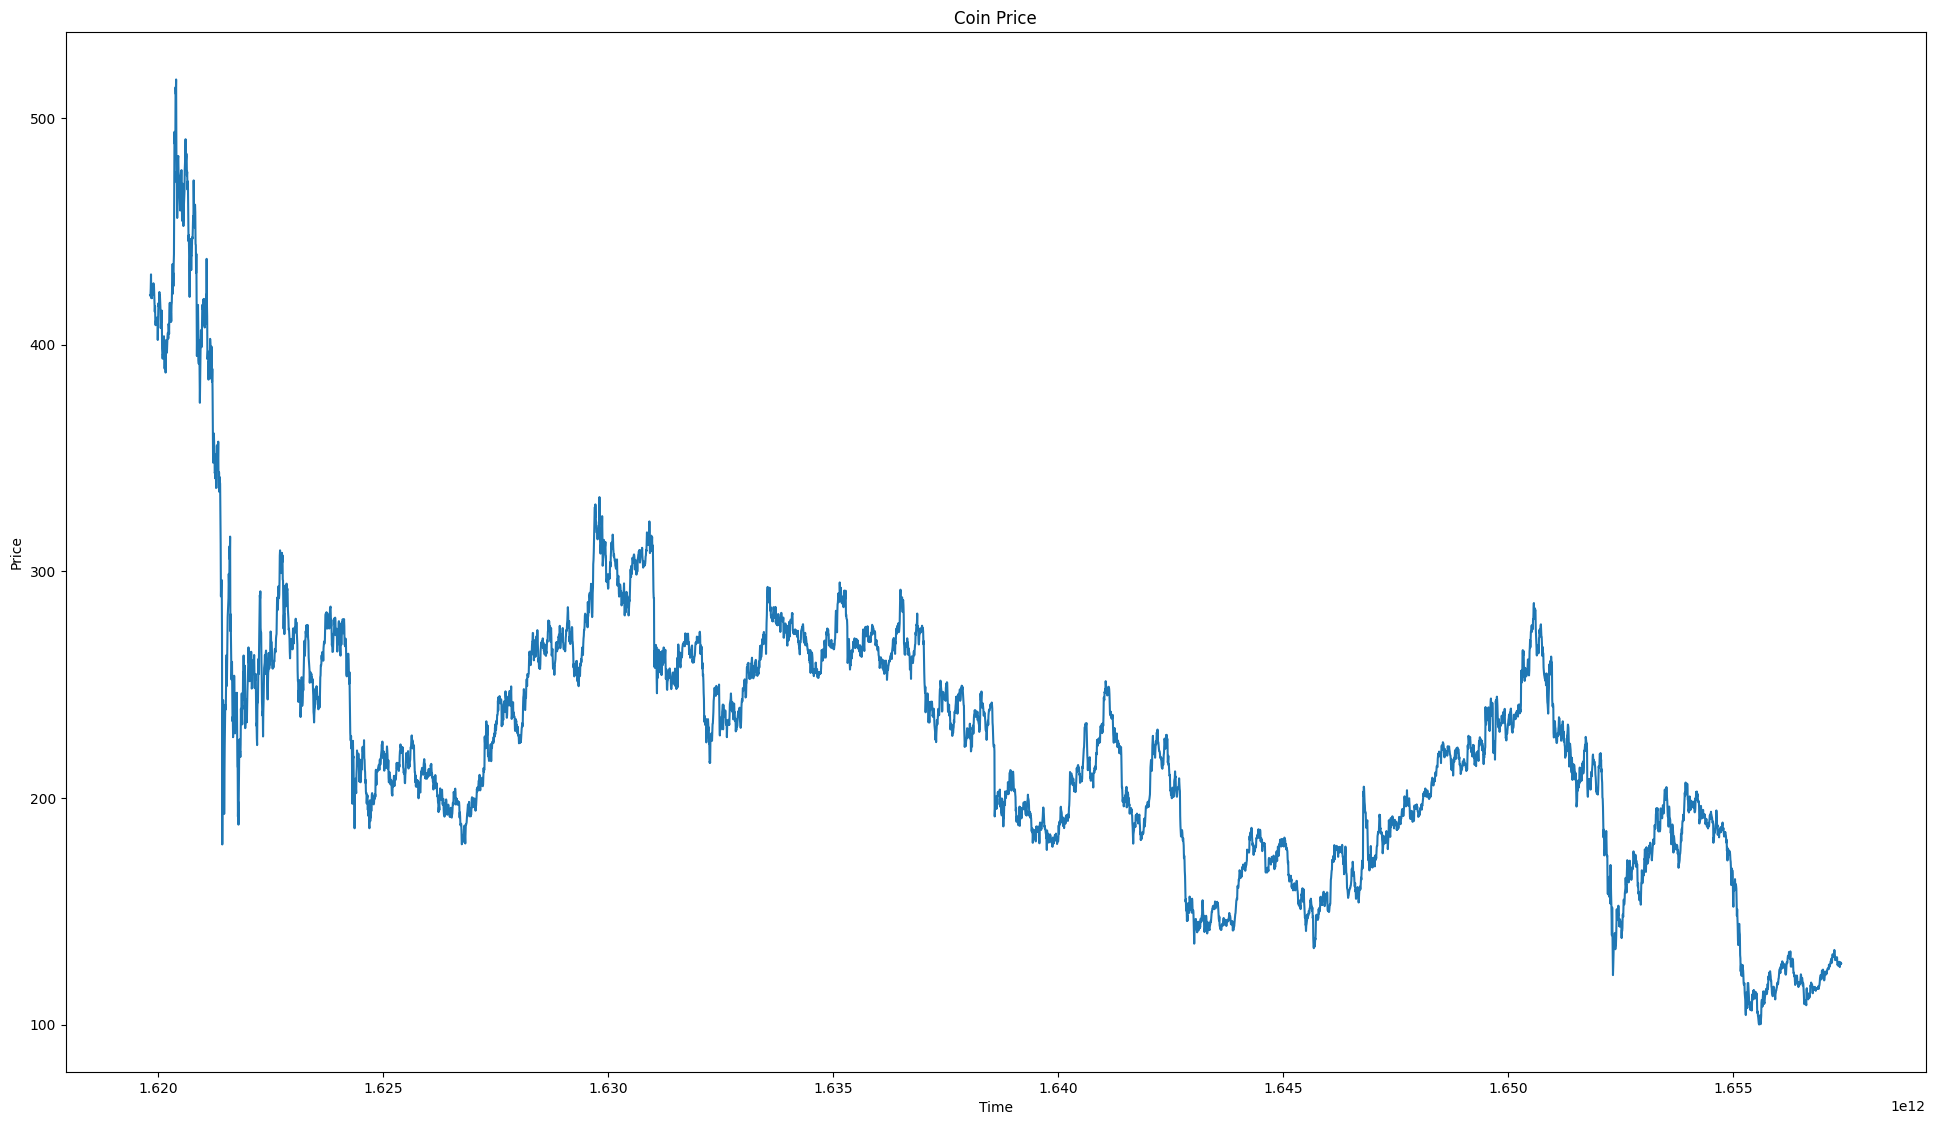

In [5]:
df = pd.DataFrame({"timestamp": timestamps, "price": prices}).set_index("timestamp")
df.price.iloc[::100].plot(title="Coin Price", xlabel="Time", ylabel="Price")

In [6]:
# choose a slice on which to test
wsize_days = 465
ts = int(data[-1][0] - 60 * 60 * 24 * 1000 * wsize_days)
idx = np.argmax(data[:, 0] >= ts)
dataslice = data[idx:]

In [7]:
hand_tuned = {
    "config_name": "hand_tuned",
    "logging_level": 0,
    "long": {
        "enabled": True,
        "ema_span_0": 1000,  # in minutes
        "ema_span_1": 1400,
        "eprice_exp_base": 1.05,
        "eqty_exp_base": 2.5,
        "grid_span": 0.16,
        "initial_qty_pct": 0.007,
        "initial_eprice_ema_dist": -0.08,  # negative is closer; positive is further away
        "markup_range": 0.018,
        "max_n_entry_orders": 8,
        "min_markup": 0.002,
        "n_close_orders": 9,
        "wallet_exposure_limit": 1.0,
        "auto_unstuck_wallet_exposure_threshold": 0.03,  # percentage of wallet_exposure_limit to trigger auto unstuck.
        "auto_unstuck_ema_dist": 0.01,
        "backwards_tp": True,
    },  # positive is further away; negative is closer
    "short": {
        "enabled": True,
        "ema_span_0": 1440,  # in minutes
        "ema_span_1": 4320,
        "eprice_exp_base": 1.05,
        "eqty_exp_base": 1.8,
        "grid_span": 0.16,
        "initial_qty_pct": 0.009,
        "initial_eprice_ema_dist": -0.07,  # negative is closer; positive is further away
        "markup_range": 0.018,
        "max_n_entry_orders": 12,
        "min_markup": 0.002,
        "n_close_orders": 9,
        "wallet_exposure_limit": 1.0,
        "auto_unstuck_wallet_exposure_threshold": 0.04,
        "auto_unstuck_ema_dist": 0.01,
        "backwards_tp": True,
    },
}

# hand_tuned = load_live_config('configs/live/allround.json')
# hand_tuned['short']['enabled'] = True
config["starting_balance"] = Args().starting_balance
config["latency_simulation_ms"] = 1000
config_to_test = {**config, **numpyize(hand_tuned)}
dump_live_config(config_to_test, make_get_filepath(f"tmp/hand_tuned.json"))
hand_tuned

{'config_name': 'hand_tuned',
 'logging_level': 0,
 'long': {'enabled': True,
  'ema_span_0': 1000,
  'ema_span_1': 1400,
  'eprice_exp_base': 1.05,
  'eqty_exp_base': 2.5,
  'grid_span': 0.16,
  'initial_qty_pct': 0.007,
  'initial_eprice_ema_dist': -0.08,
  'markup_range': 0.018,
  'max_n_entry_orders': 8,
  'min_markup': 0.002,
  'n_close_orders': 9,
  'wallet_exposure_limit': 1.0,
  'auto_unstuck_wallet_exposure_threshold': 0.03,
  'auto_unstuck_ema_dist': 0.01,
  'backwards_tp': True},
 'short': {'enabled': True,
  'ema_span_0': 1440,
  'ema_span_1': 4320,
  'eprice_exp_base': 1.05,
  'eqty_exp_base': 1.8,
  'grid_span': 0.16,
  'initial_qty_pct': 0.009,
  'initial_eprice_ema_dist': -0.07,
  'markup_range': 0.018,
  'max_n_entry_orders': 12,
  'min_markup': 0.002,
  'n_close_orders': 9,
  'wallet_exposure_limit': 1.0,
  'auto_unstuck_wallet_exposure_threshold': 0.04,
  'auto_unstuck_ema_dist': 0.01,
  'backwards_tp': True}}

In [8]:
sts = time()
fills_long, fills_short, stats = backtest(config_to_test, dataslice)
elapsed = time() - sts
print(f"seconds elapsed {elapsed:.4f}")
longs, shorts, sdf, analysis = analyze_fills(fills_long, fills_short, stats, config_to_test)
pprint.pprint(analysis)

seconds elapsed 49.4547
{'DGstd_long': 0.03622782242025538,
 'DGstd_short': 0.018706513311318198,
 'adg_DGstd_ratio_long': 0.039866976428200016,
 'adg_DGstd_ratio_short': 0.11487014516452304,
 'adg_long': 0.0014442937424733373,
 'adg_per_exposure_long': 0.0014442937424733373,
 'adg_per_exposure_short': 0.002148819899593204,
 'adg_realized_long': 0.0007485668258566669,
 'adg_realized_per_exposure_long': 0.0007485668258566669,
 'adg_realized_per_exposure_short': 0.001975399064645833,
 'adg_realized_short': 0.001975399064645833,
 'adg_short': 0.002148819899593204,
 'avg_fills_per_day_long': 8.179323402495854,
 'avg_fills_per_day_short': 9.491969176196003,
 'biggest_psize_long': 135.666,
 'biggest_psize_quote_long': 13444.363529999999,
 'biggest_psize_quote_short': 23340.376093145365,
 'biggest_psize_short': 179.298,
 'closest_bkr_long': 0.9997450358234066,
 'closest_bkr_short': 0.7250512011915147,
 'eqbal_ratio_mean_long': 0.984904927057696,
 'eqbal_ratio_mean_short': 0.9913018607407831,


In [9]:
sdf

,timestamp,bkr_price_long,bkr_price_short,psize_long,pprice_long,psize_short,pprice_short,price,closest_bkr_long,closest_bkr_short,balance_long,balance_short,equity_long,equity_short,wallet_exposure_long,wallet_exposure_short
0,1619827320000.0,0.0,0.0000000000,0.000,0.0000000000,0.000,0.0000000000,421.82,1.0000000000,1.0000000000,10000.000000000,10000.0000000000,10000.000000000,10000.0000000000,0.0000000000,0.0000000000
1,1619827380000.0,0.0,0.0000000000,0.000,0.0000000000,0.000,0.0000000000,421.73,1.0000000000,1.0000000000,10000.000000000,10000.0000000000,10000.000000000,10000.0000000000,0.0000000000,0.0000000000
2,1619827440000.0,0.0,0.0000000000,0.000,0.0000000000,0.000,0.0000000000,421.32,1.0000000000,1.0000000000,10000.000000000,10000.0000000000,10000.000000000,10000.0000000000,0.0000000000,0.0000000000
3,1619827500000.0,0.0,0.0000000000,0.000,0.0000000000,0.000,0.0000000000,420.93,1.0000000000,1.0000000000,10000.000000000,10000.0000000000,10000.000000000,10000.0000000000,0.0000000000,0.0000000000
4,1619827560000.0,0.0,0.0000000000,0.000,0.0000000000,0.000,0.0000000000,419.75,1.0000000000,1.0000000000,10000.000000000,10000.0000000000,10000.000000000,10000.0000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626395,1657411020000.0,0.0,4491.9365670823,5.352,127.6819749626,-5.405,126.5346956522,127.03,0.9997450358,0.7250512012,13847.286969442,23594.9971150799,13843.797599442,23592.3199950799,0.0493493008,0.0289858069
626396,1657411080000.0,0.0,4491.9365670823,5.352,127.6819749626,-5.405,126.5346956522,127.02,0.9997450358,0.7250512012,13847.286969442,23594.9971150799,13843.744079442,23592.3740450799,0.0493493008,0.0289858069
626397,1657411140000.0,0.0,4491.9365670823,5.352,127.6819749626,-5.405,126.5346956522,127.01,0.9997450358,0.7250512012,13847.286969442,23594.9971150799,13843.690559442,23592.4280950799,0.0493493008,0.0289858069
626398,1657411200000.0,0.0,4491.9365670823,5.352,127.6819749626,-5.405,126.5346956522,127.03,0.9997450358,0.7250512012,13847.286969442,23594.9971150799,13843.797599442,23592.3199950799,0.0493493008,0.0289858069


<AxesSubplot:title={'center':'Balance and equity long'}, xlabel='Time', ylabel='Balance'>

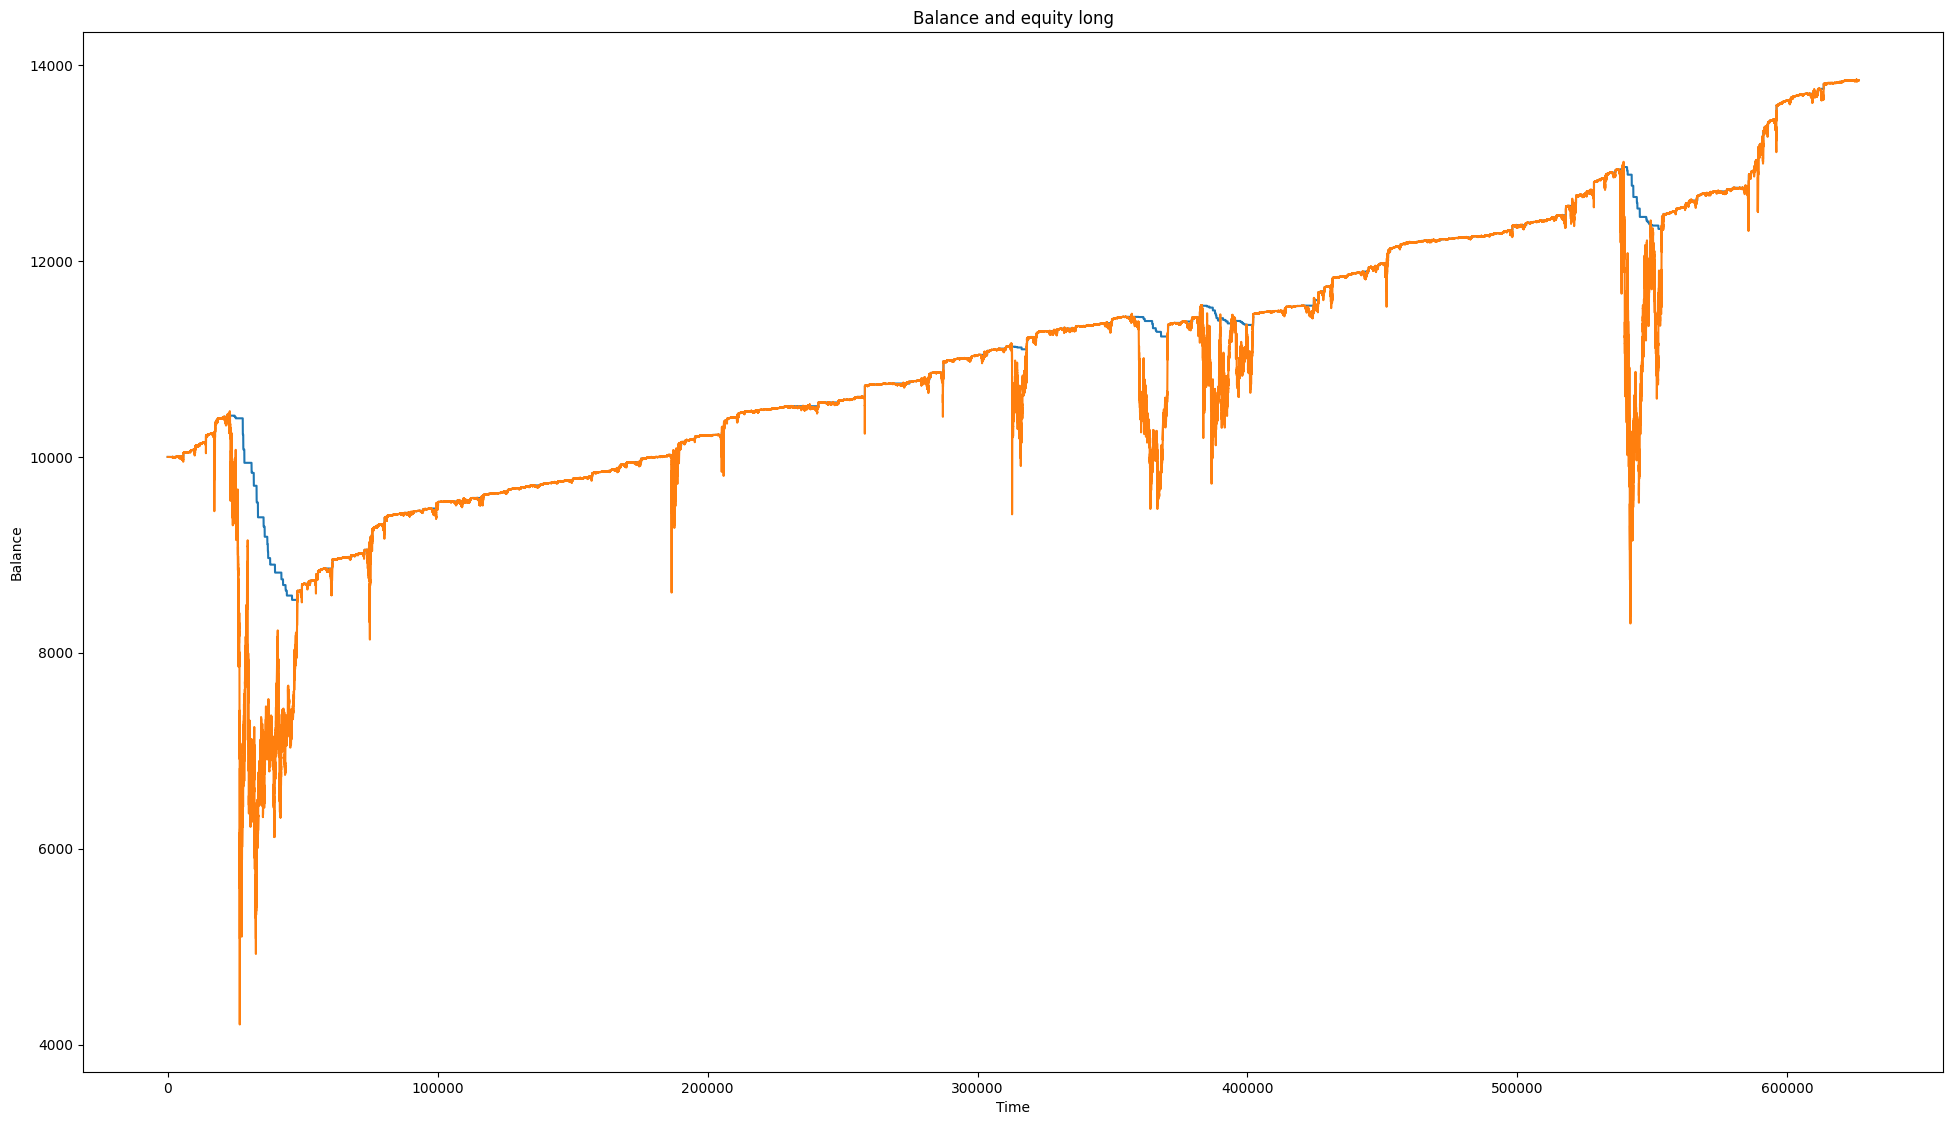

In [10]:
sdf.balance_long.plot()
sdf.equity_long.plot(title="Balance and equity long", xlabel="Time", ylabel="Balance")

<AxesSubplot:title={'center':'Balance and equity short'}, xlabel='Time', ylabel='Balance'>

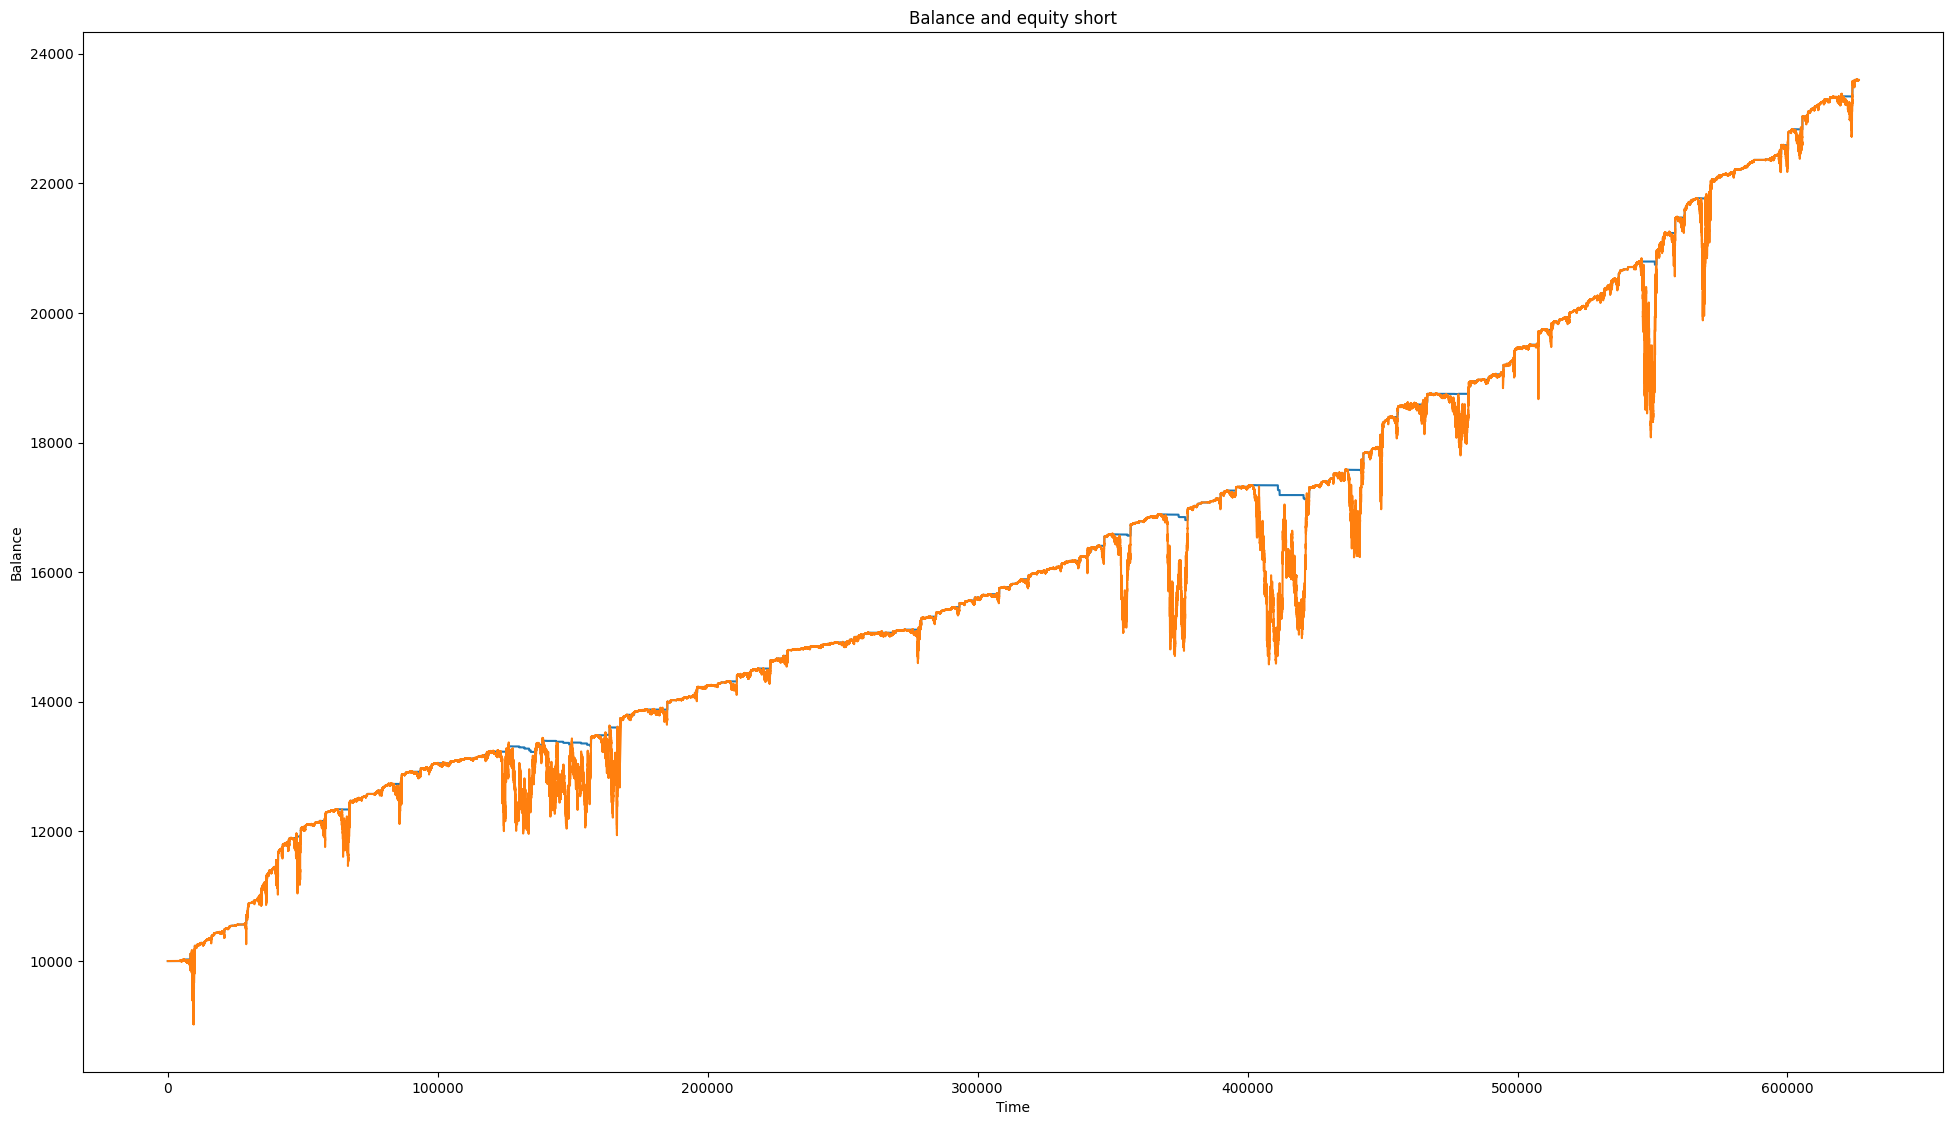

In [11]:
sdf.balance_short.plot()
sdf.equity_short.plot(title="Balance and equity short", xlabel="Time", ylabel="Balance")

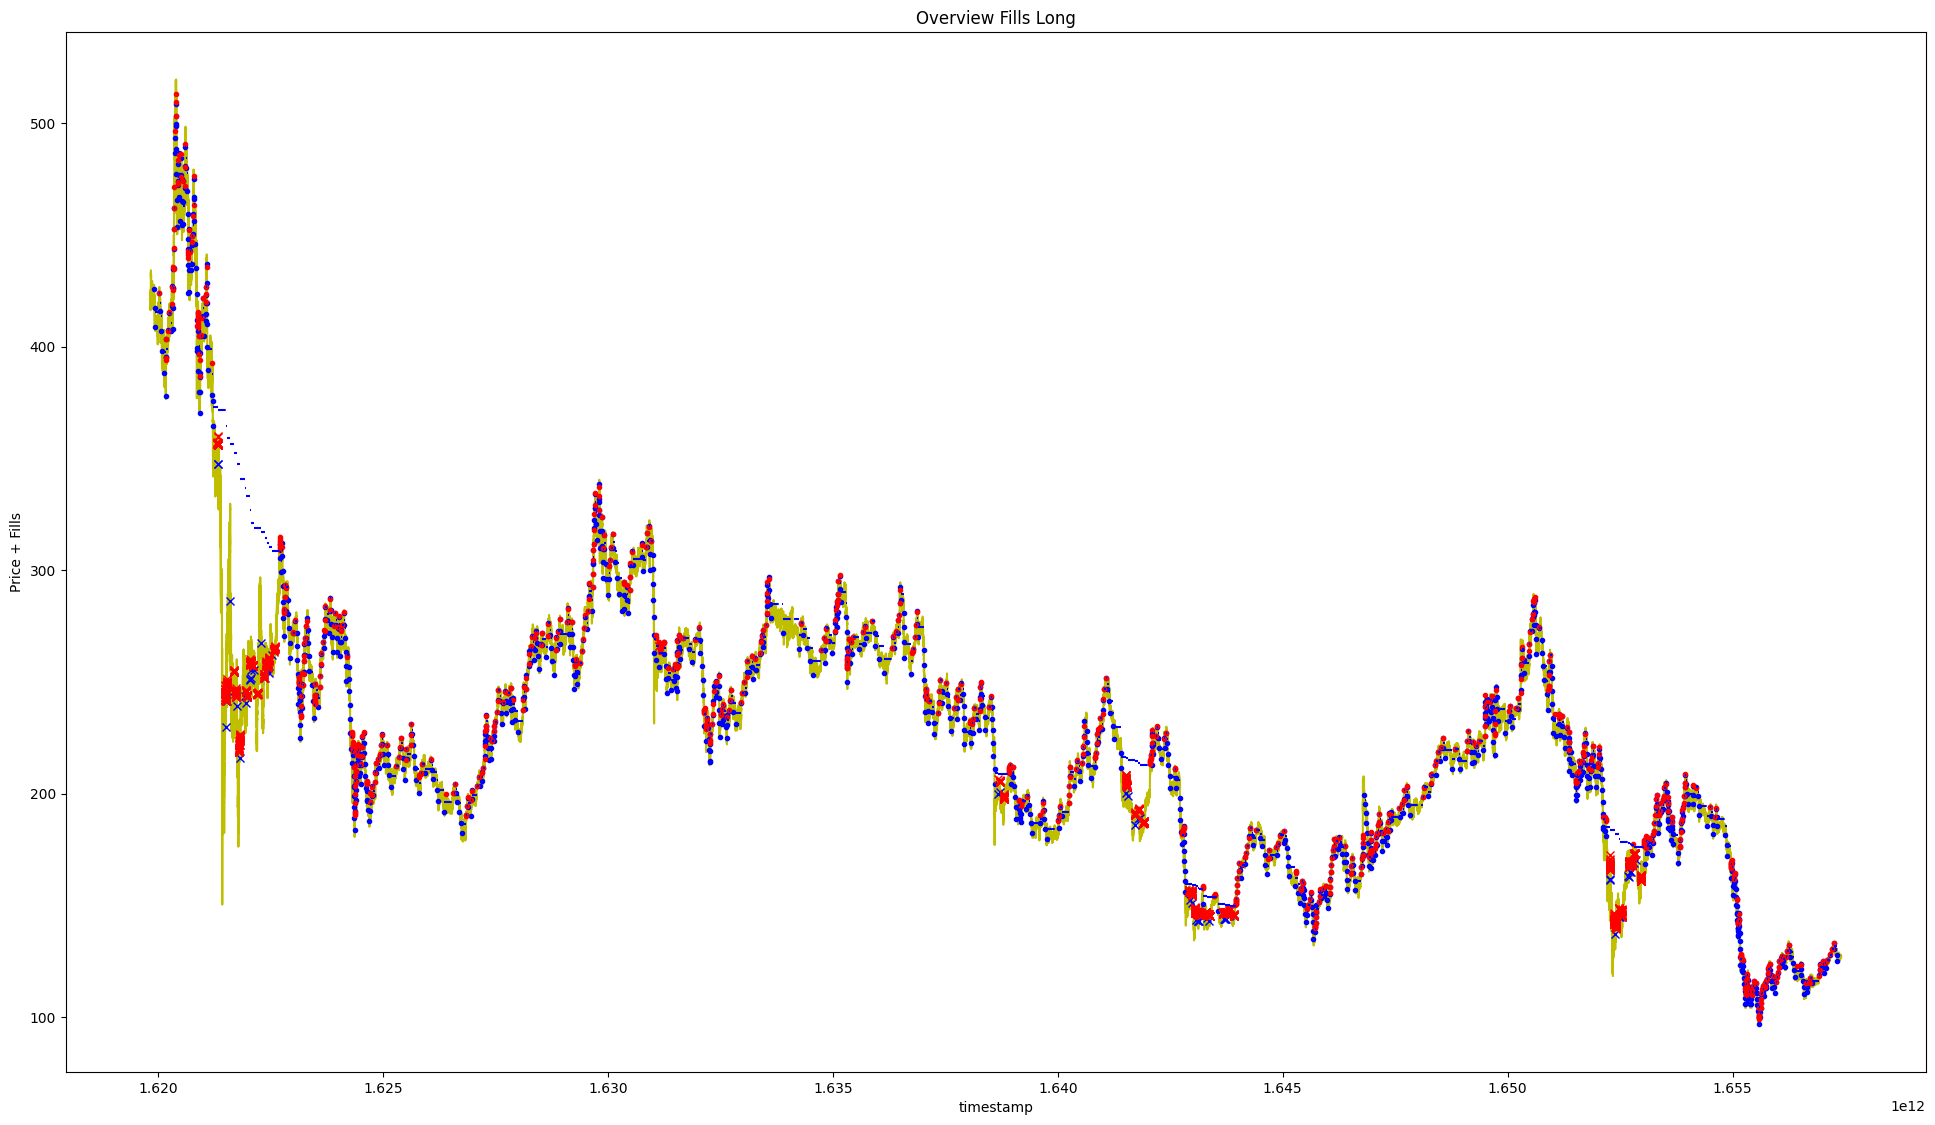

In [12]:
if len(longs) > 0:
    plot_fills(df, longs, plot_whole_df=True, title="Overview Fills Long")

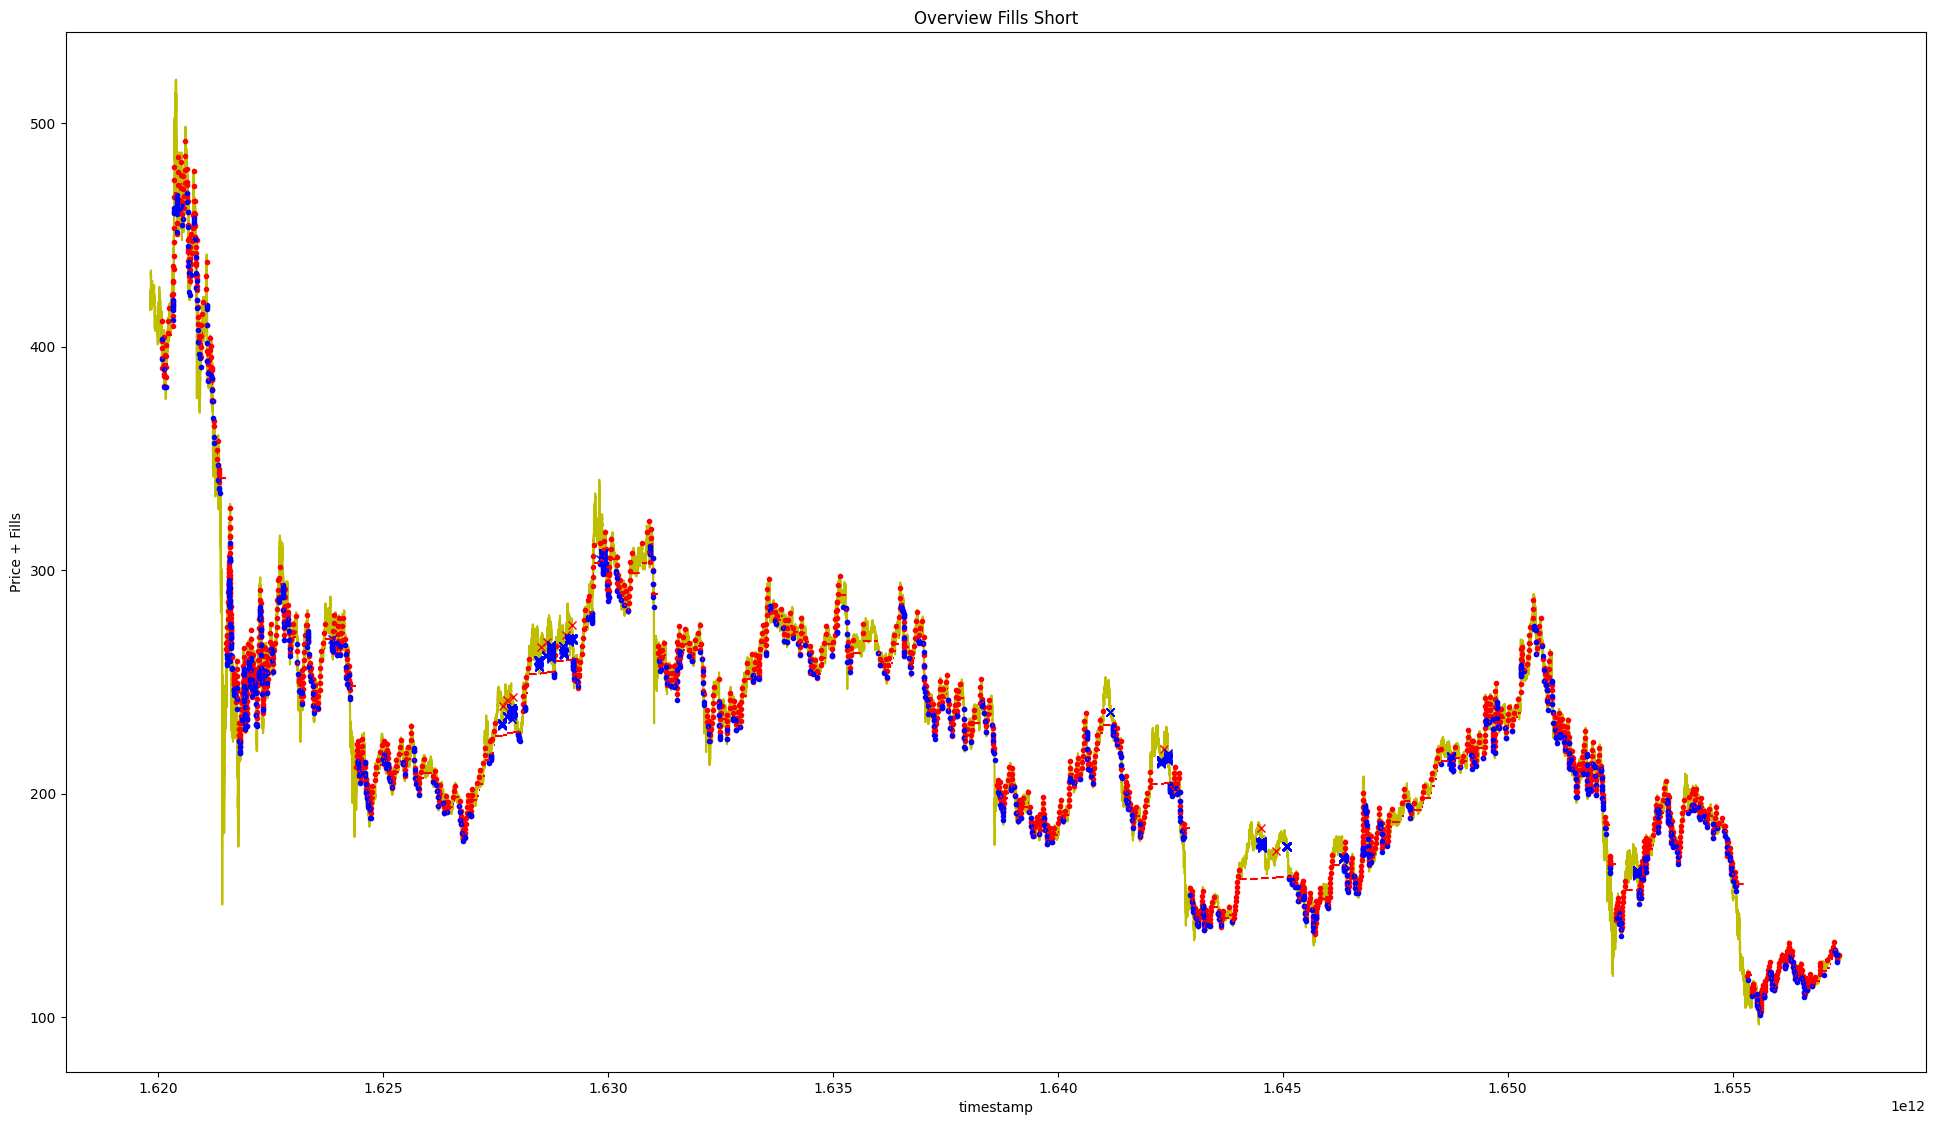

In [13]:
if len(shorts) > 0:
    plot_fills(df, shorts, plot_whole_df=True, title="Overview Fills Short")

<AxesSubplot:title={'center':'Position size in terms of contracts'}, xlabel='Time', ylabel='Long Position size'>

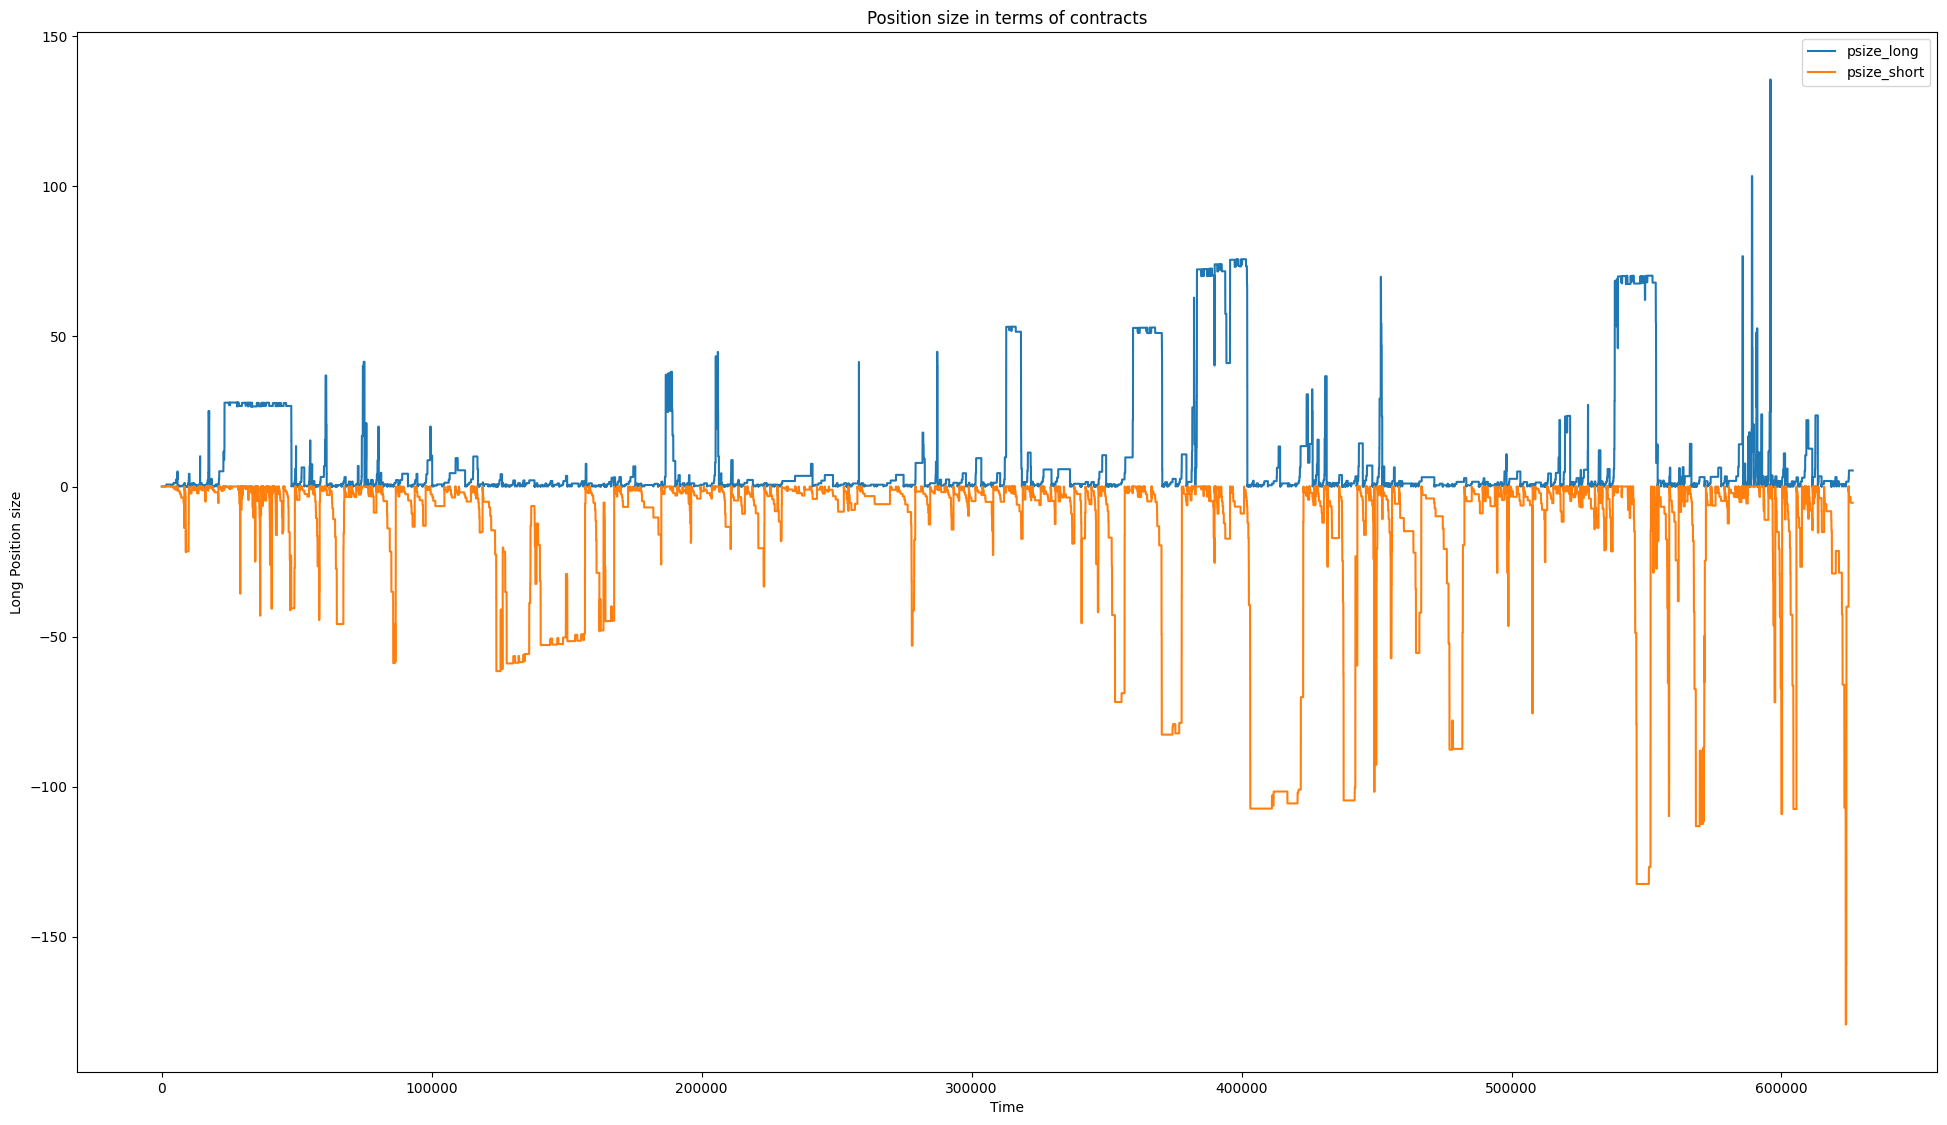

In [14]:
sdf[["psize_long", "psize_short"]].plot(
    title="Position size in terms of contracts", xlabel="Time", ylabel="Long Position size"
)

<AxesSubplot:title={'center':'Average entry price'}, xlabel='Time', ylabel='Price'>

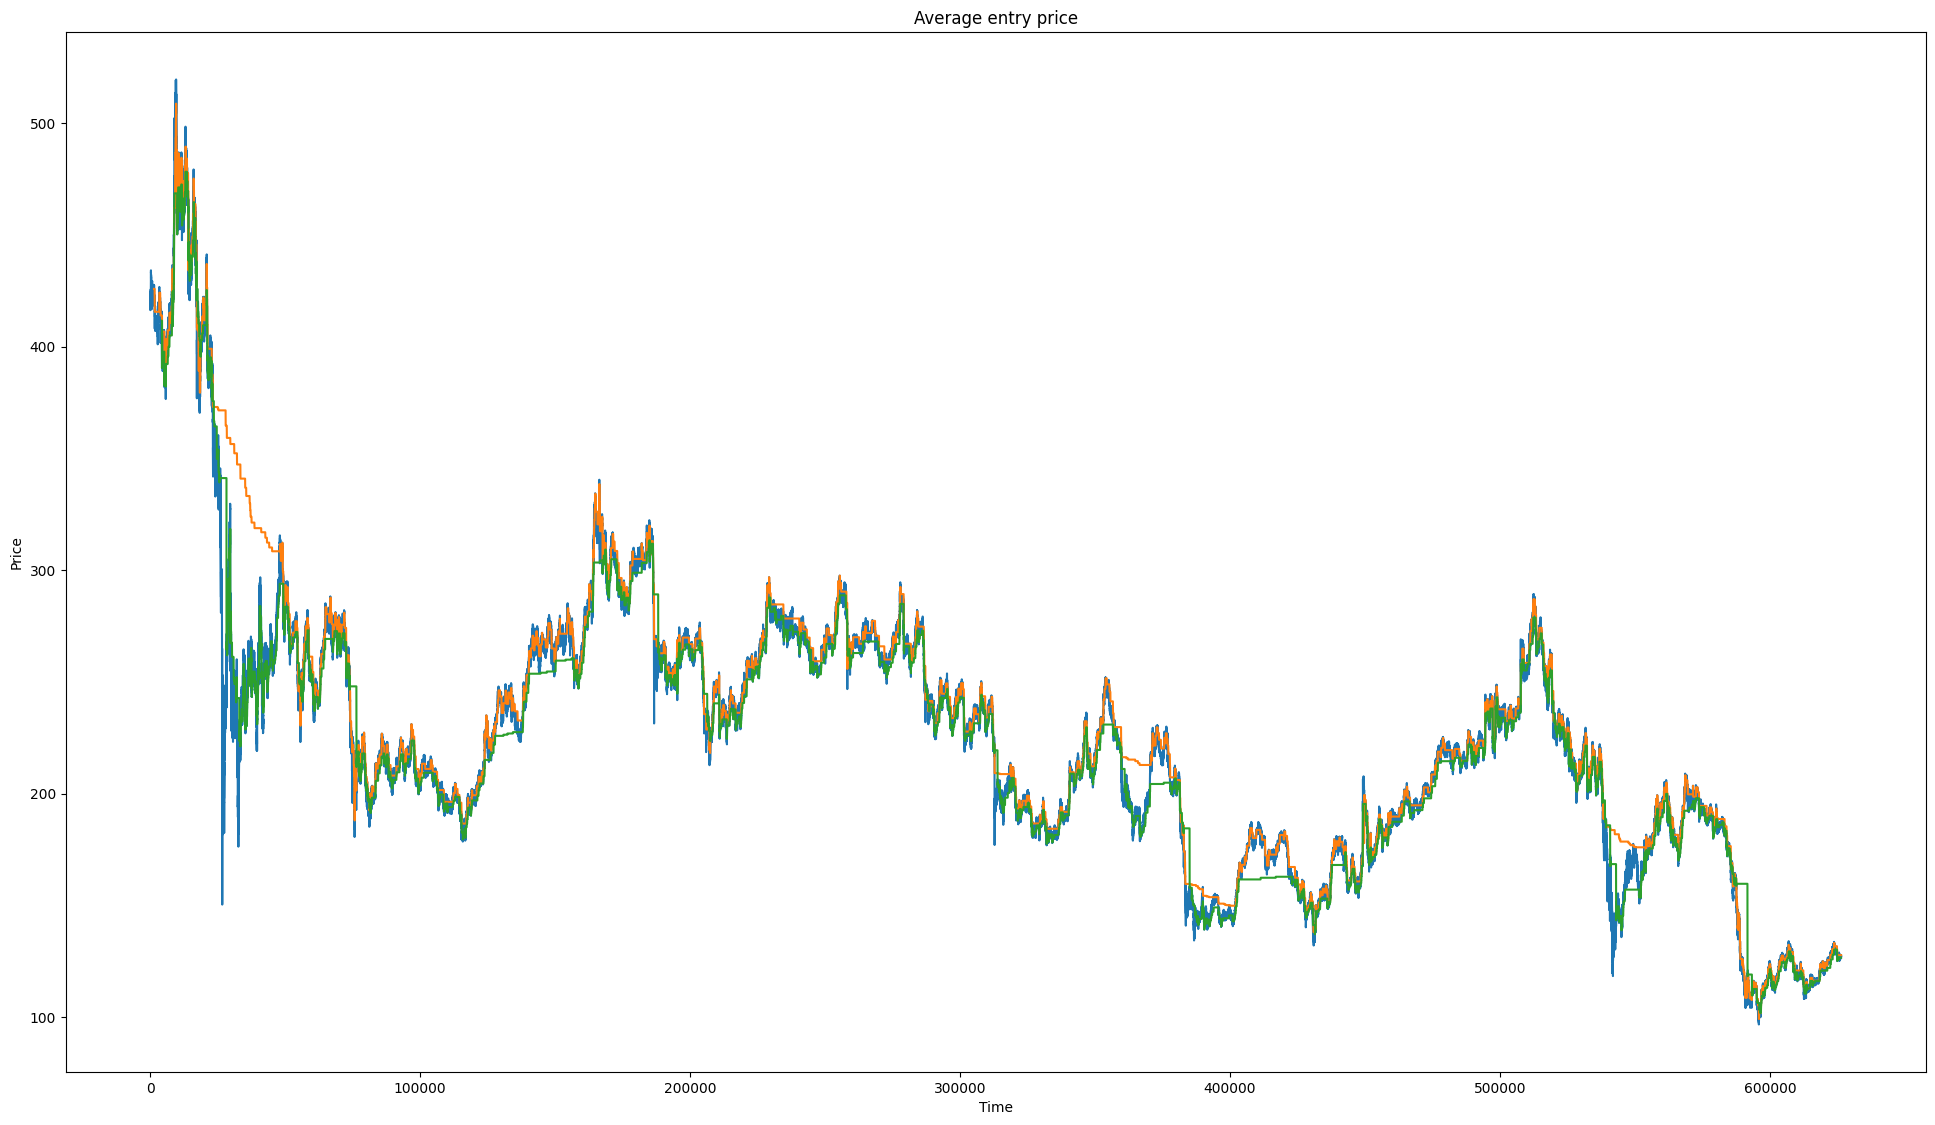

In [15]:
sdf.price.plot(title="Average entry price", xlabel="Time", ylabel="Price")
sdf.pprice_long.replace(0.0, np.nan).plot()
sdf.pprice_short.replace(0.0, np.nan).plot()

Mean price action distance long 0.028897


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

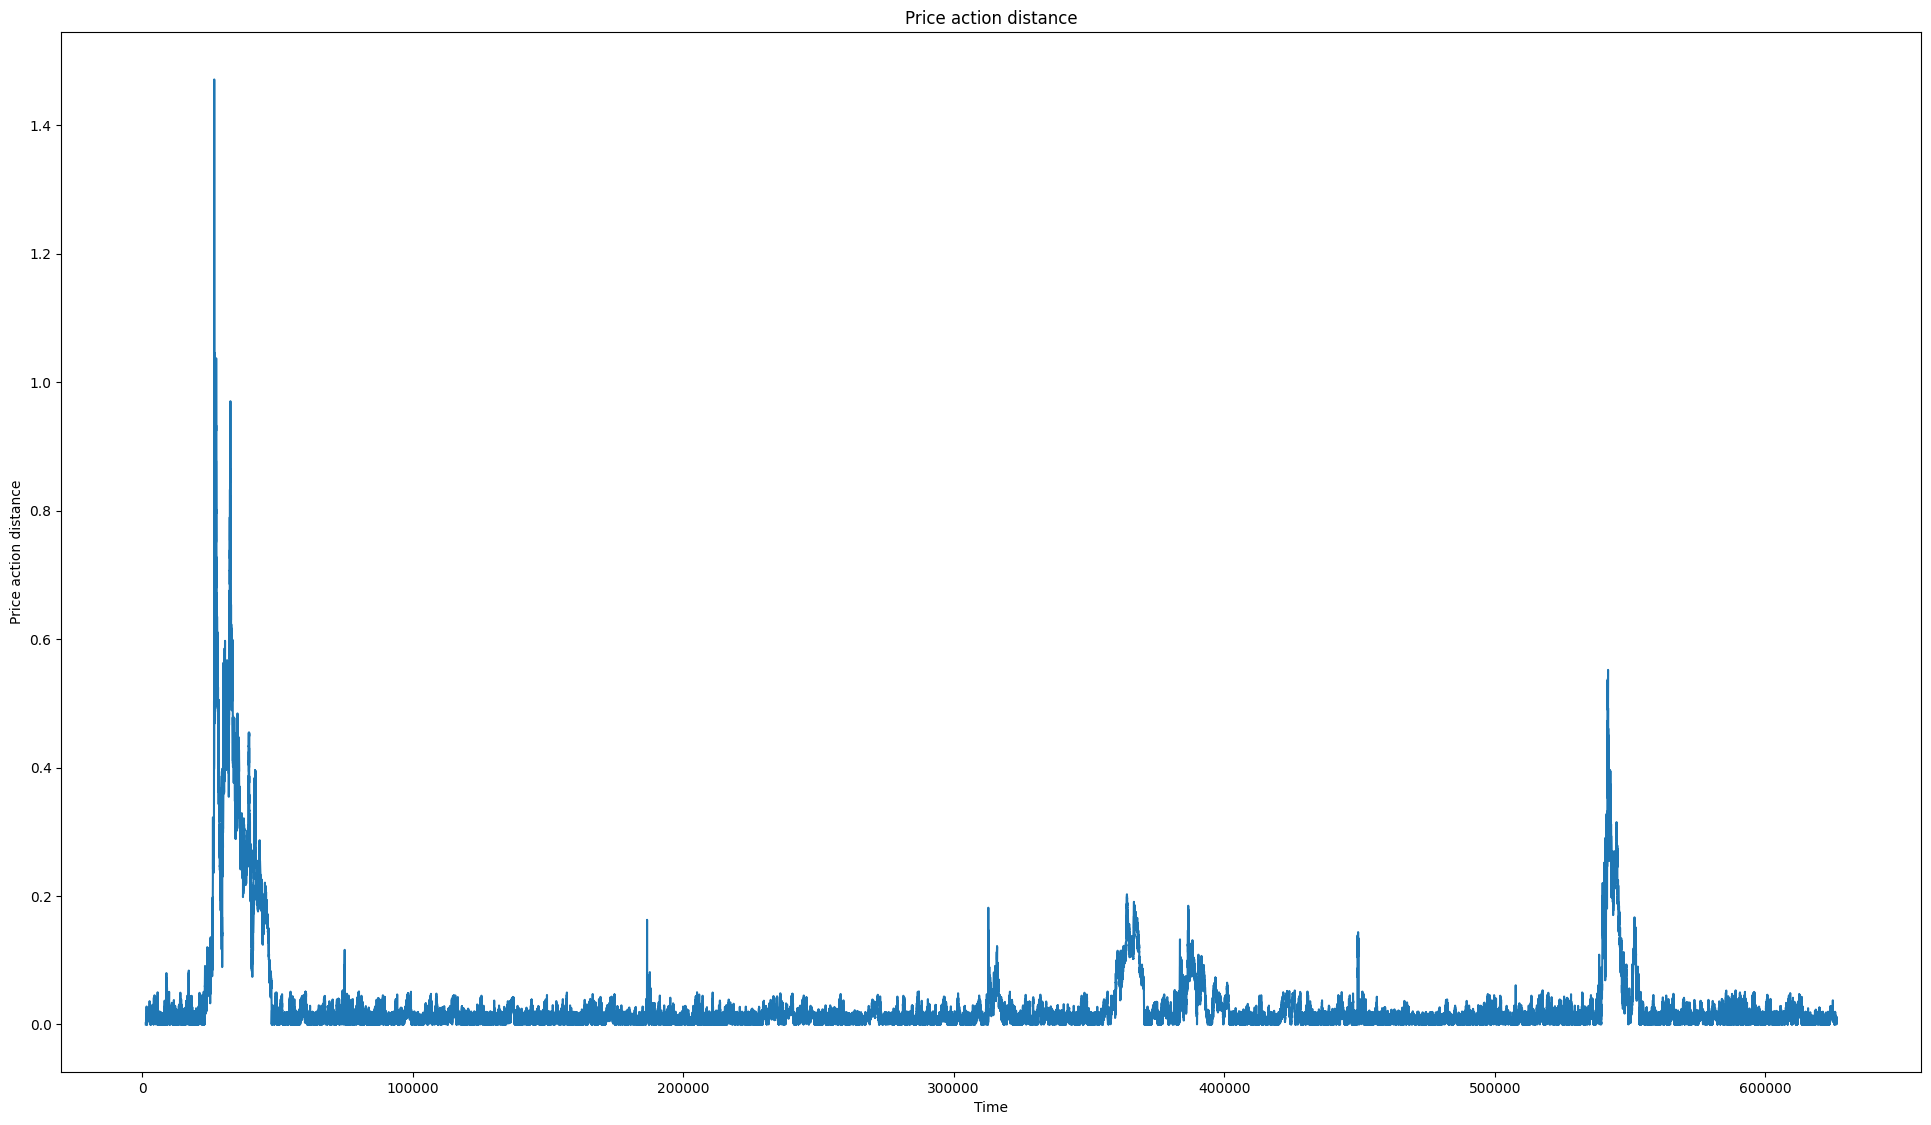

In [16]:
lpprices = sdf[sdf.pprice_long != 0.0]
pa_distance_long = (lpprices.pprice_long - lpprices.price).abs() / lpprices.price
print(f"Mean price action distance long {pa_distance_long.mean():.6f}")
pa_distance_long.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

Mean price action distance short 0.025002


<AxesSubplot:title={'center':'Price action distance'}, xlabel='Time', ylabel='Price action distance'>

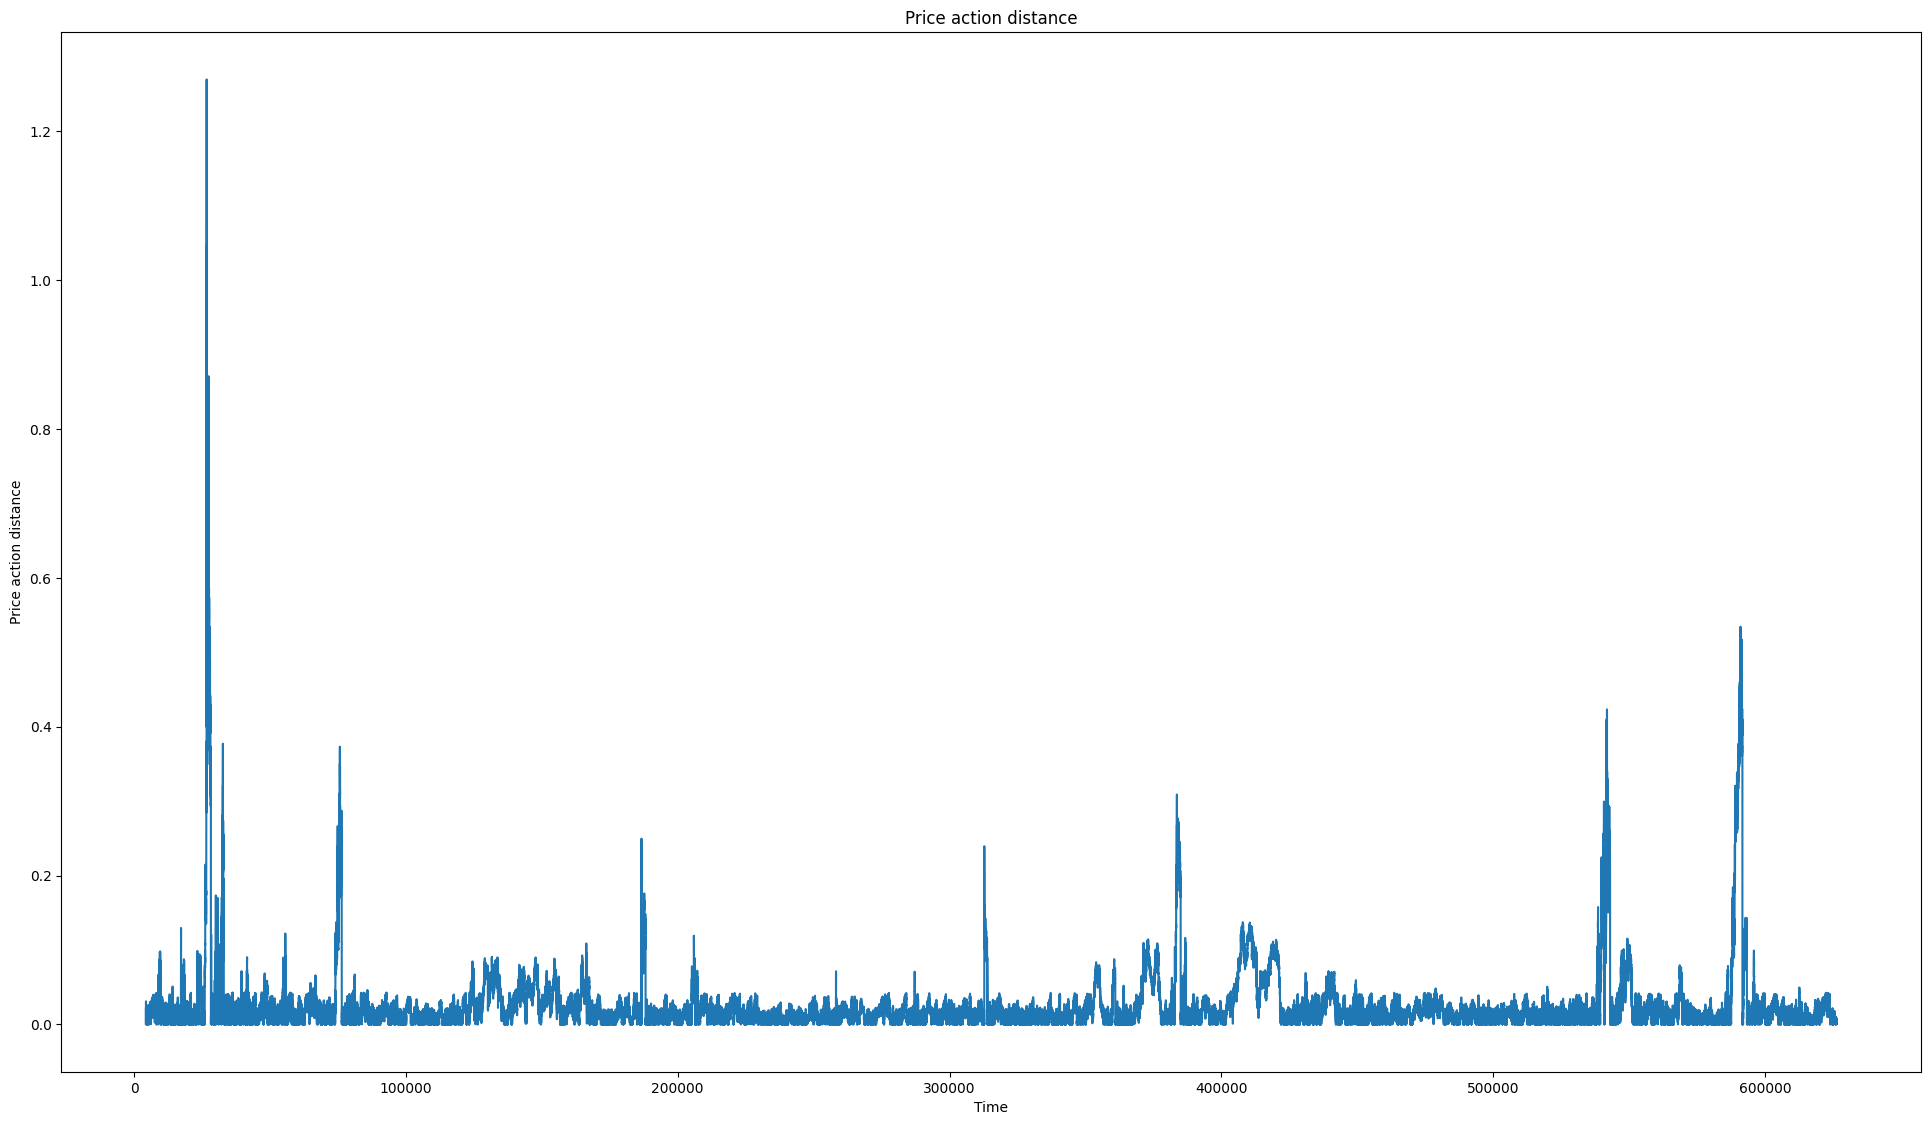

In [17]:
spprices = sdf[sdf.pprice_short != 0.0]
pa_distance_short = (spprices.pprice_short - spprices.price).abs() / spprices.price
print(f"Mean price action distance short {pa_distance_short.mean():.6f}")
pa_distance_short.plot(title="Price action distance", xlabel="Time", ylabel="Price action distance")

spans in minutes [1000, 1183.2159566199232, 1400] n_days 435.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

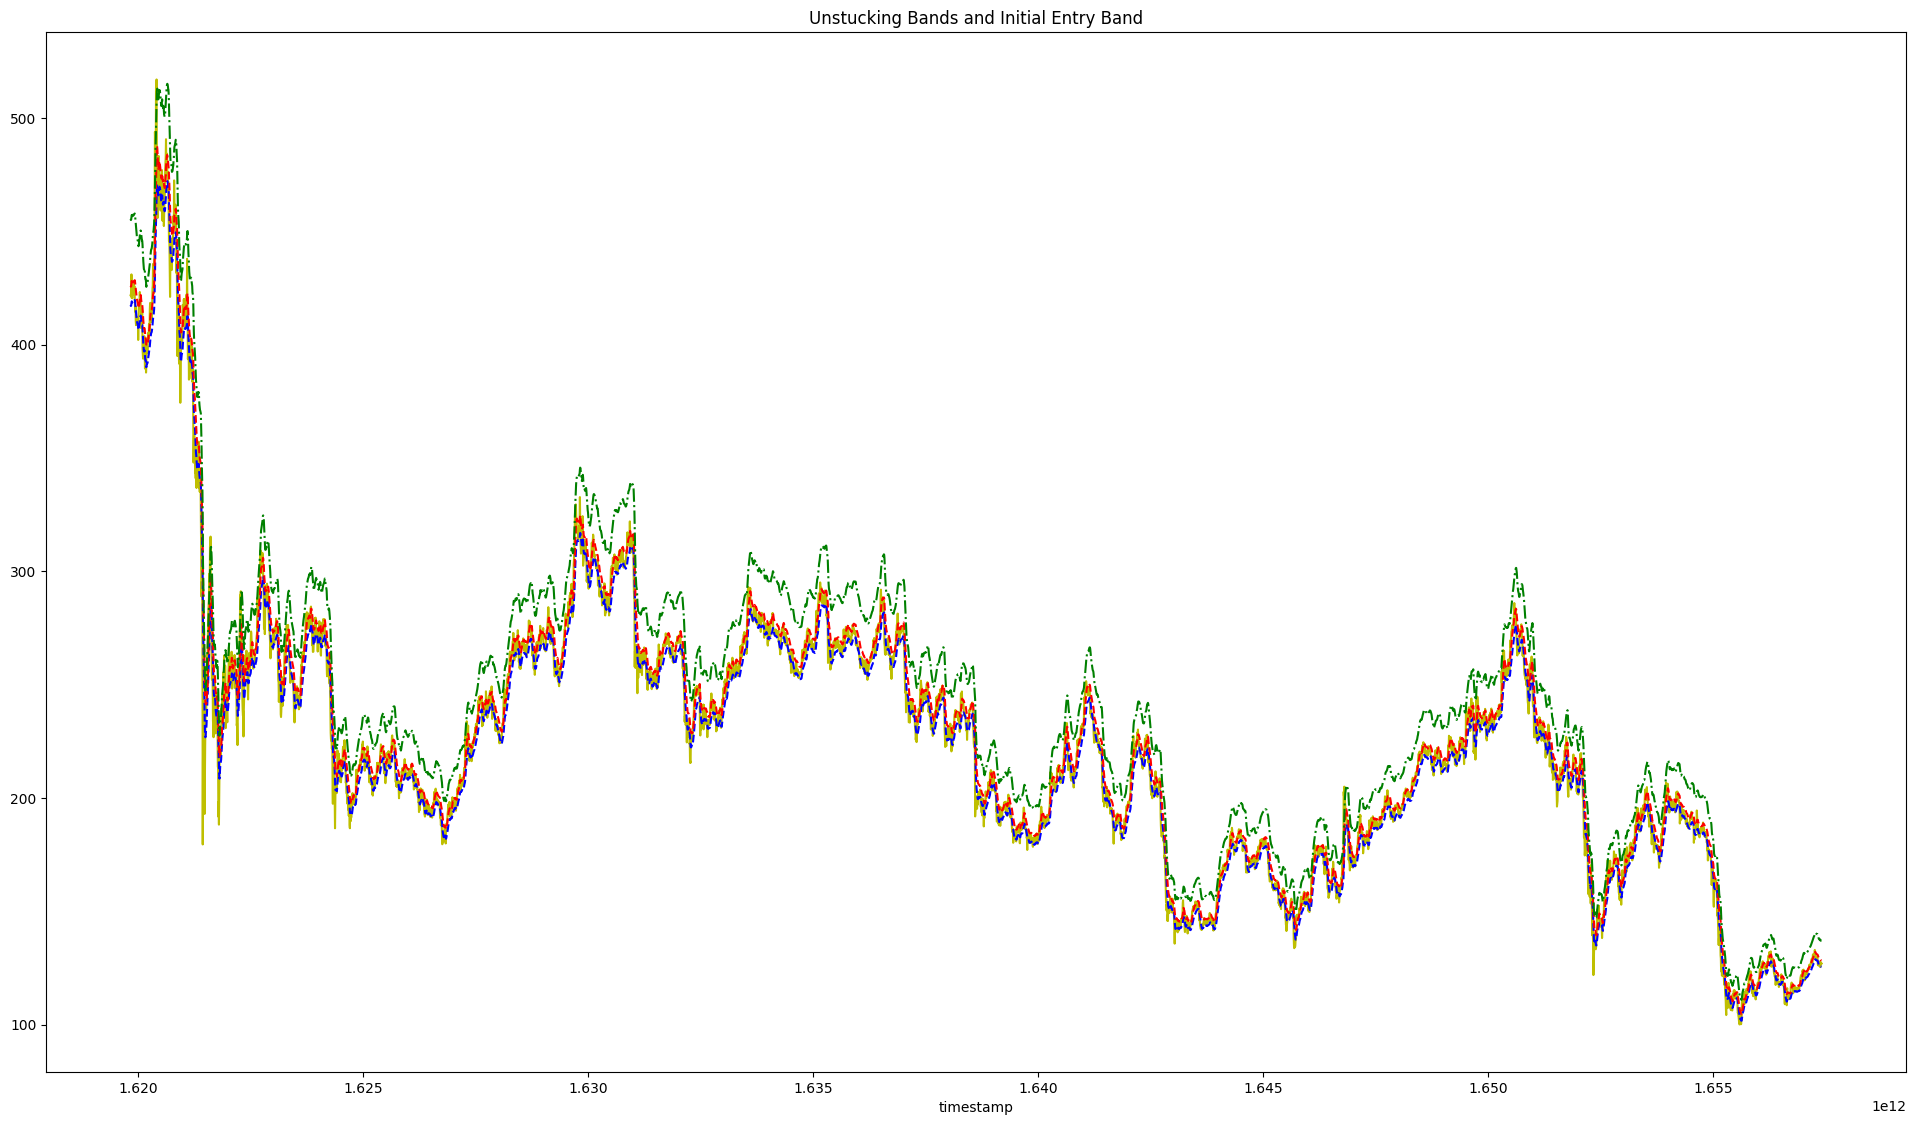

In [18]:
# Inspect long EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["long"]["ema_span_0"],
    (config_to_test["long"]["ema_span_0"] * config_to_test["long"]["ema_span_1"]) ** 0.5,
    config_to_test["long"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["long"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["long"]["auto_unstuck_ema_dist"])
long_ientry_band = ema_band_lower * (1 - config_to_test["long"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(
    style="b--",
)
unstucking_band_upper.iloc[::100].plot(style="r--")
long_ientry_band.iloc[::100].plot(style="g-.")

spans in minutes [1440, 2494.1531628991834, 4320] n_days 435.0


<AxesSubplot:title={'center':'Unstucking Bands and Initial Entry Band'}, xlabel='timestamp'>

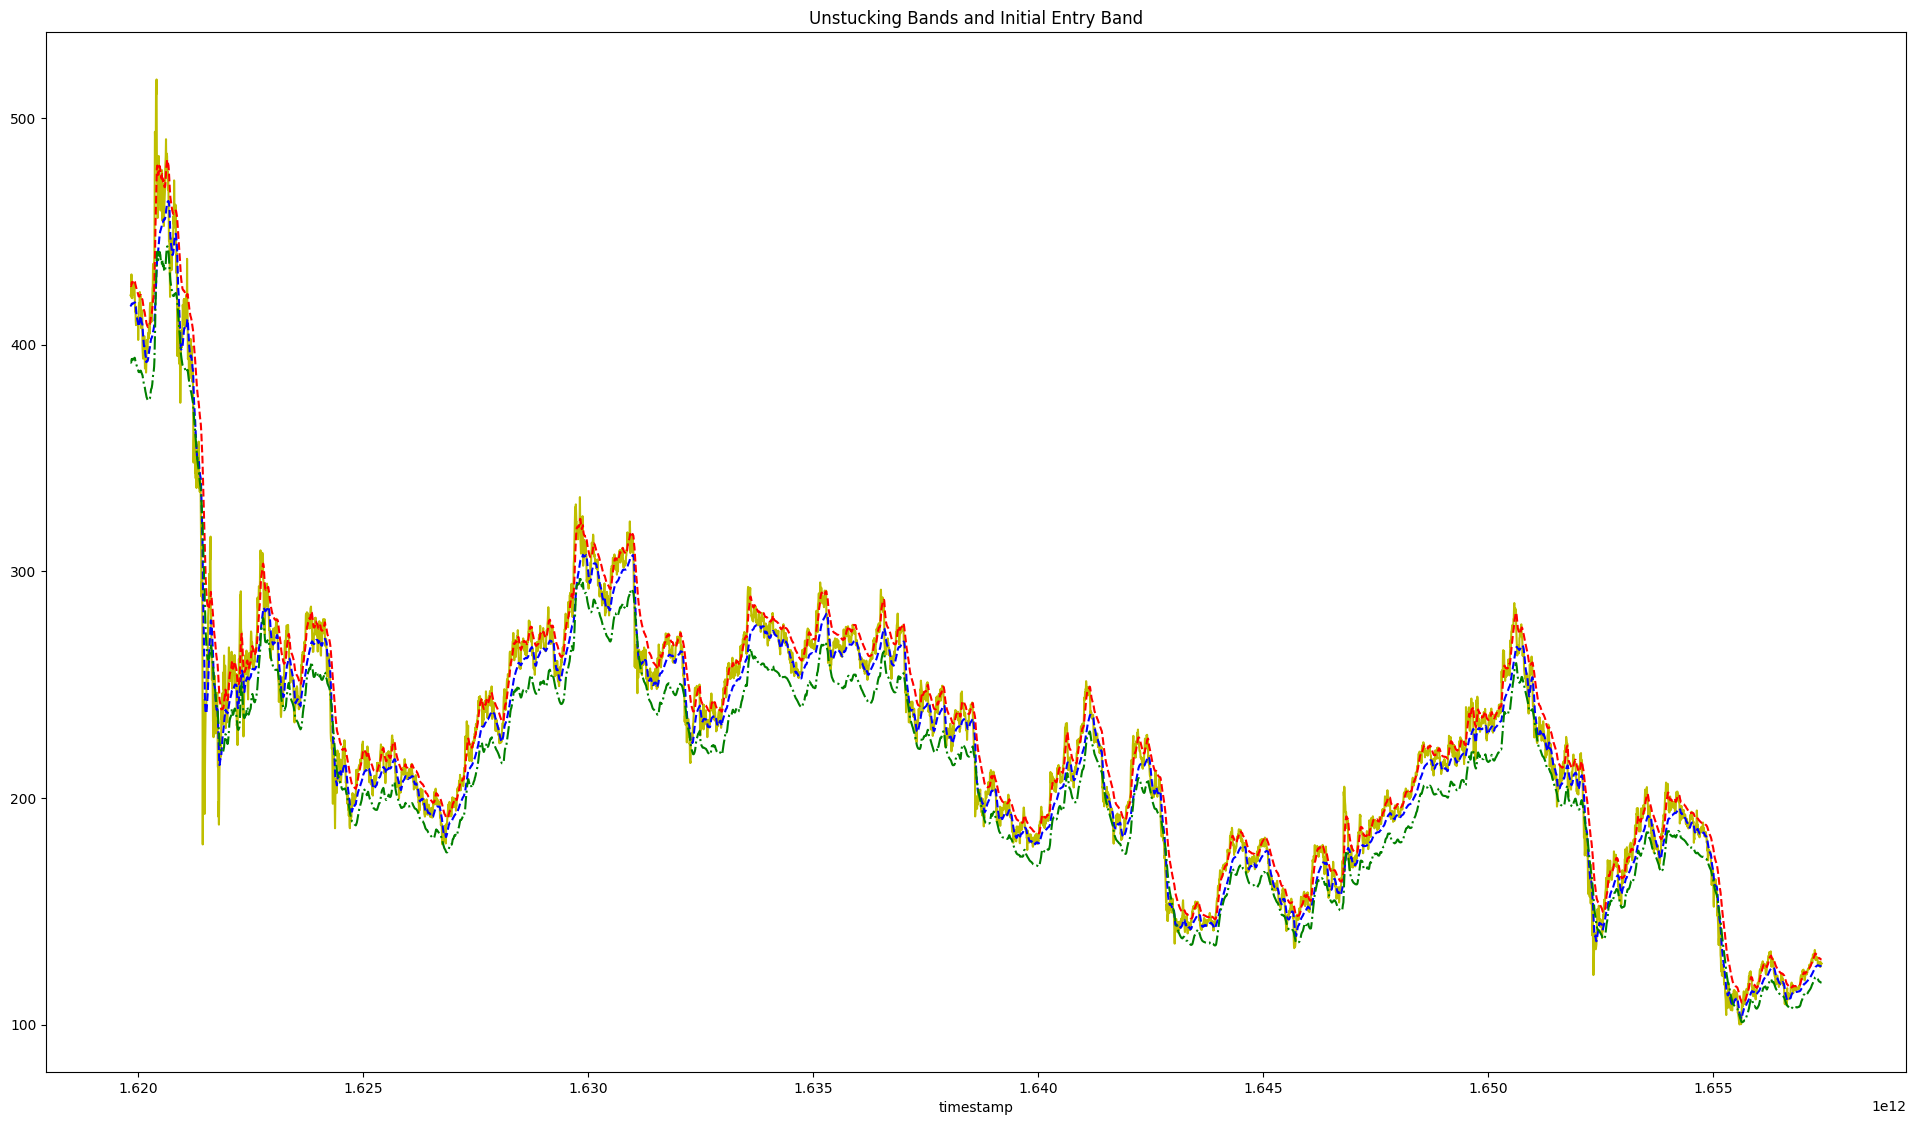

In [19]:
# Inspect short EMAs
# blue: lower unstucking; red: upper unstucking; green: initial entry
spans = [
    config_to_test["short"]["ema_span_0"],
    (config_to_test["short"]["ema_span_0"] * config_to_test["short"]["ema_span_1"]) ** 0.5,
    config_to_test["short"]["ema_span_1"],
]
print(
    f"spans in minutes {spans}",
    f"n_days {(df.index[-1] - df.index[0]) / 1000 / 60 / 60 / 24:.1f}",
)
spans_multiplier = 60 / ((timestamps[1] - timestamps[0]) / 1000)
for i in range(3):
    # change to seconds
    spans[i] = max(1.0, spans[i] * spans_multiplier)
emas = pd.DataFrame({str(span): df.price.ewm(span=span, adjust=False).mean() for span in spans})
ema_band_lower = emas.min(axis=1)
unstucking_band_lower = ema_band_lower * (1 - config_to_test["short"]["auto_unstuck_ema_dist"])
ema_band_upper = emas.max(axis=1)
unstucking_band_upper = ema_band_upper * (1 + config_to_test["short"]["auto_unstuck_ema_dist"])
short_ientry_band = ema_band_upper * (1 + config_to_test["short"]["initial_eprice_ema_dist"])
df.iloc[::100].price.plot(style="y-", title="Unstucking Bands and Initial Entry Band")
unstucking_band_lower.iloc[::100].plot(style="b--")
unstucking_band_upper.iloc[::100].plot(style="r--")
short_ientry_band.iloc[::100].plot(style="g-.")

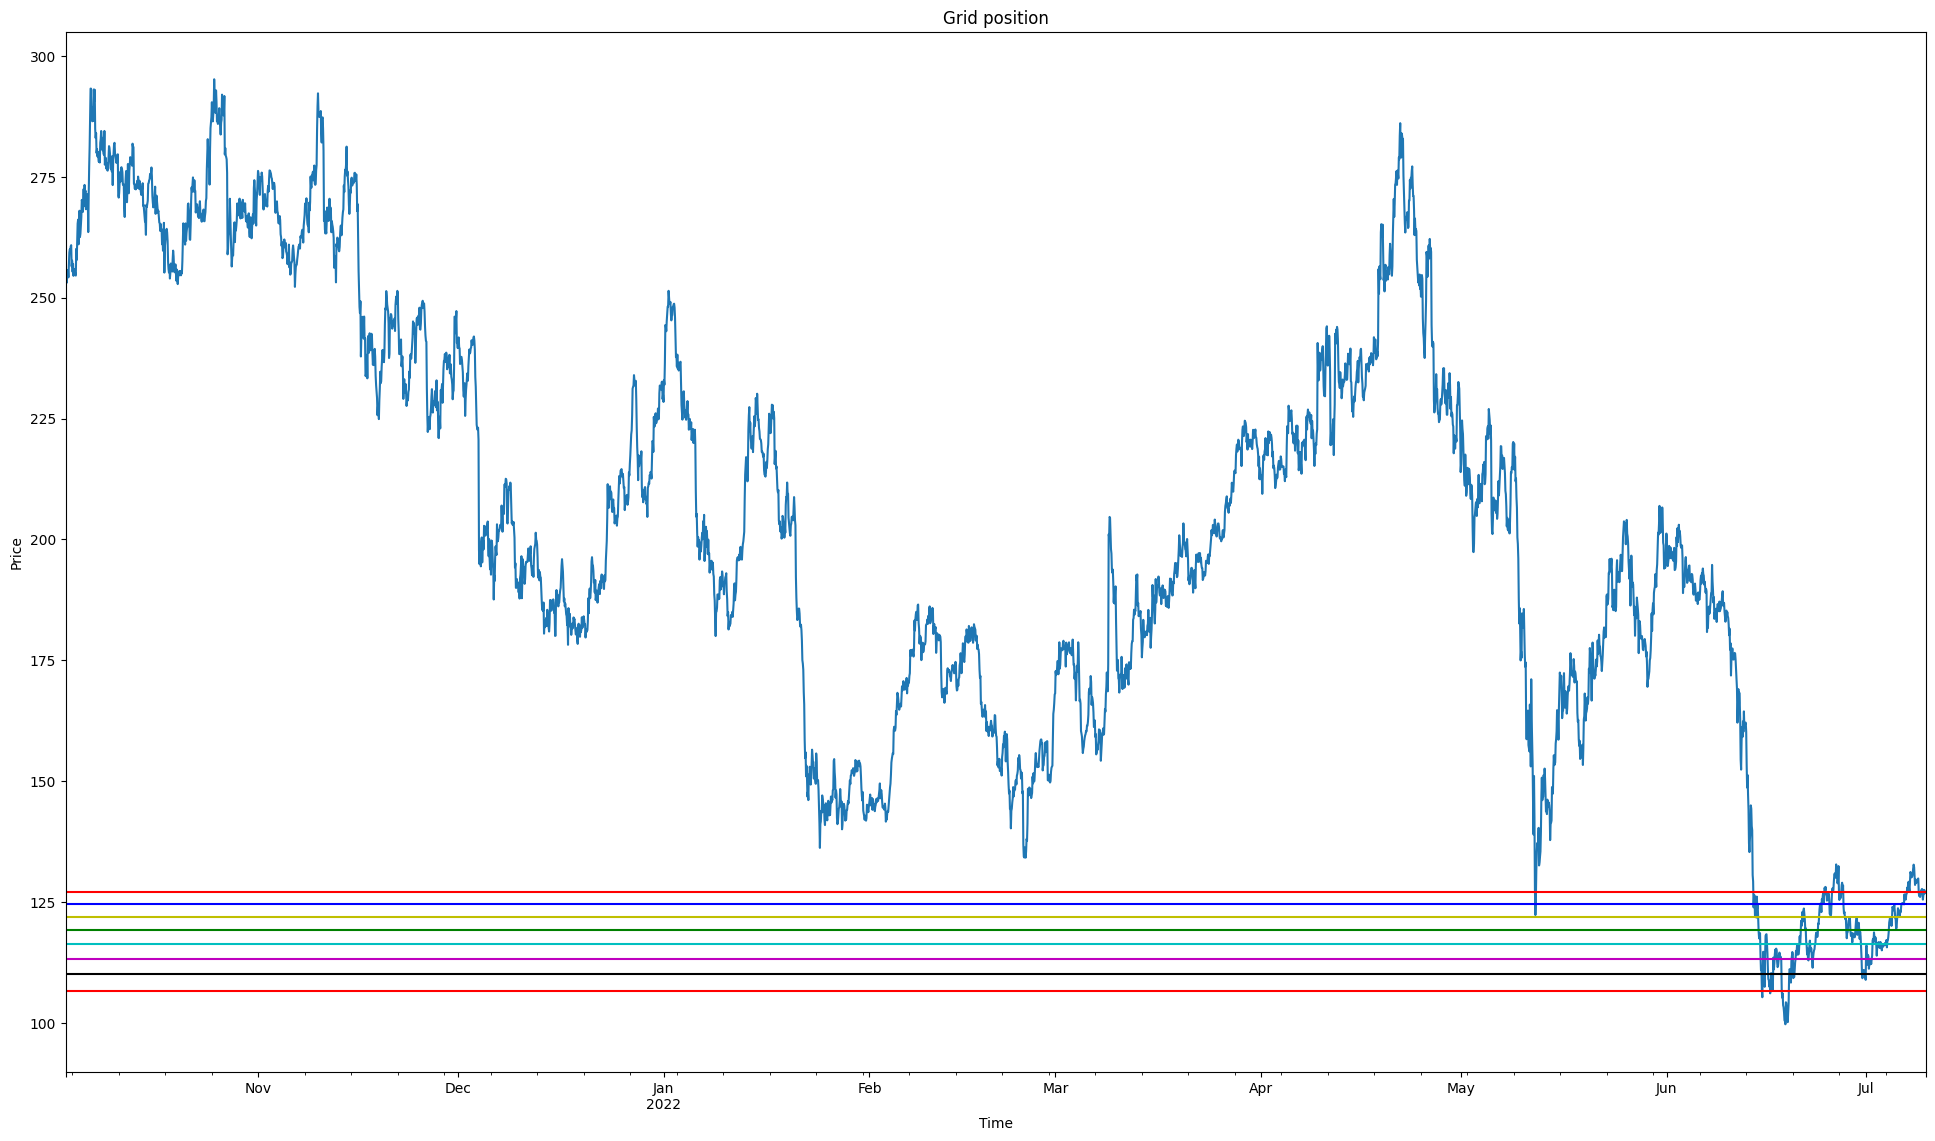

In [20]:
balance = config_to_test["starting_balance"]
highest_bid = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_long = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["long"]["grid_span"]
wallet_exposure_limit = config_to_test["long"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["long"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["long"]["initial_qty_pct"]
eqty_exp_base = config_to_test["long"]["eqty_exp_base"]
eprice_exp_base = config_to_test["long"]["eprice_exp_base"]

grid = calc_whole_neat_entry_grid_long(
    balance,
    highest_bid,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eqty_exp_base,
    eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [21]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nLong Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Long Grid Span = 16.00 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,0.551,127.03,0.551,127.0300000000,0.006999353,0.0000000000,NaN,0.0000000000
1,0.681,124.53,1.232,125.6481006494,0.015479846,0.0089785646,1.2359346642,0.0000000000
2,1.005,121.91,2.237,123.9687125615,0.027731801,0.0168871509,0.8157467532,0.0000000000
3,1.815,119.16,4.052,121.8147606120,0.049359341,0.0222789578,0.8113544926,0.0000000000
4,3.841,116.27,7.893,119.1164930951,0.094018648,0.0244817502,0.9479269497,0.0000000000
5,8.905,113.23,16.798,115.9959298726,0.194849963,0.0244275357,1.1282148739,0.0000000000
6,21.566,110.05,38.364,112.6534753936,0.432183793,0.0236572048,1.2838433147,0.0000000000
7,53.217,106.70,91.581,109.1939575895,1.000009183,0.0233735482,1.3871598373,0.0010027189


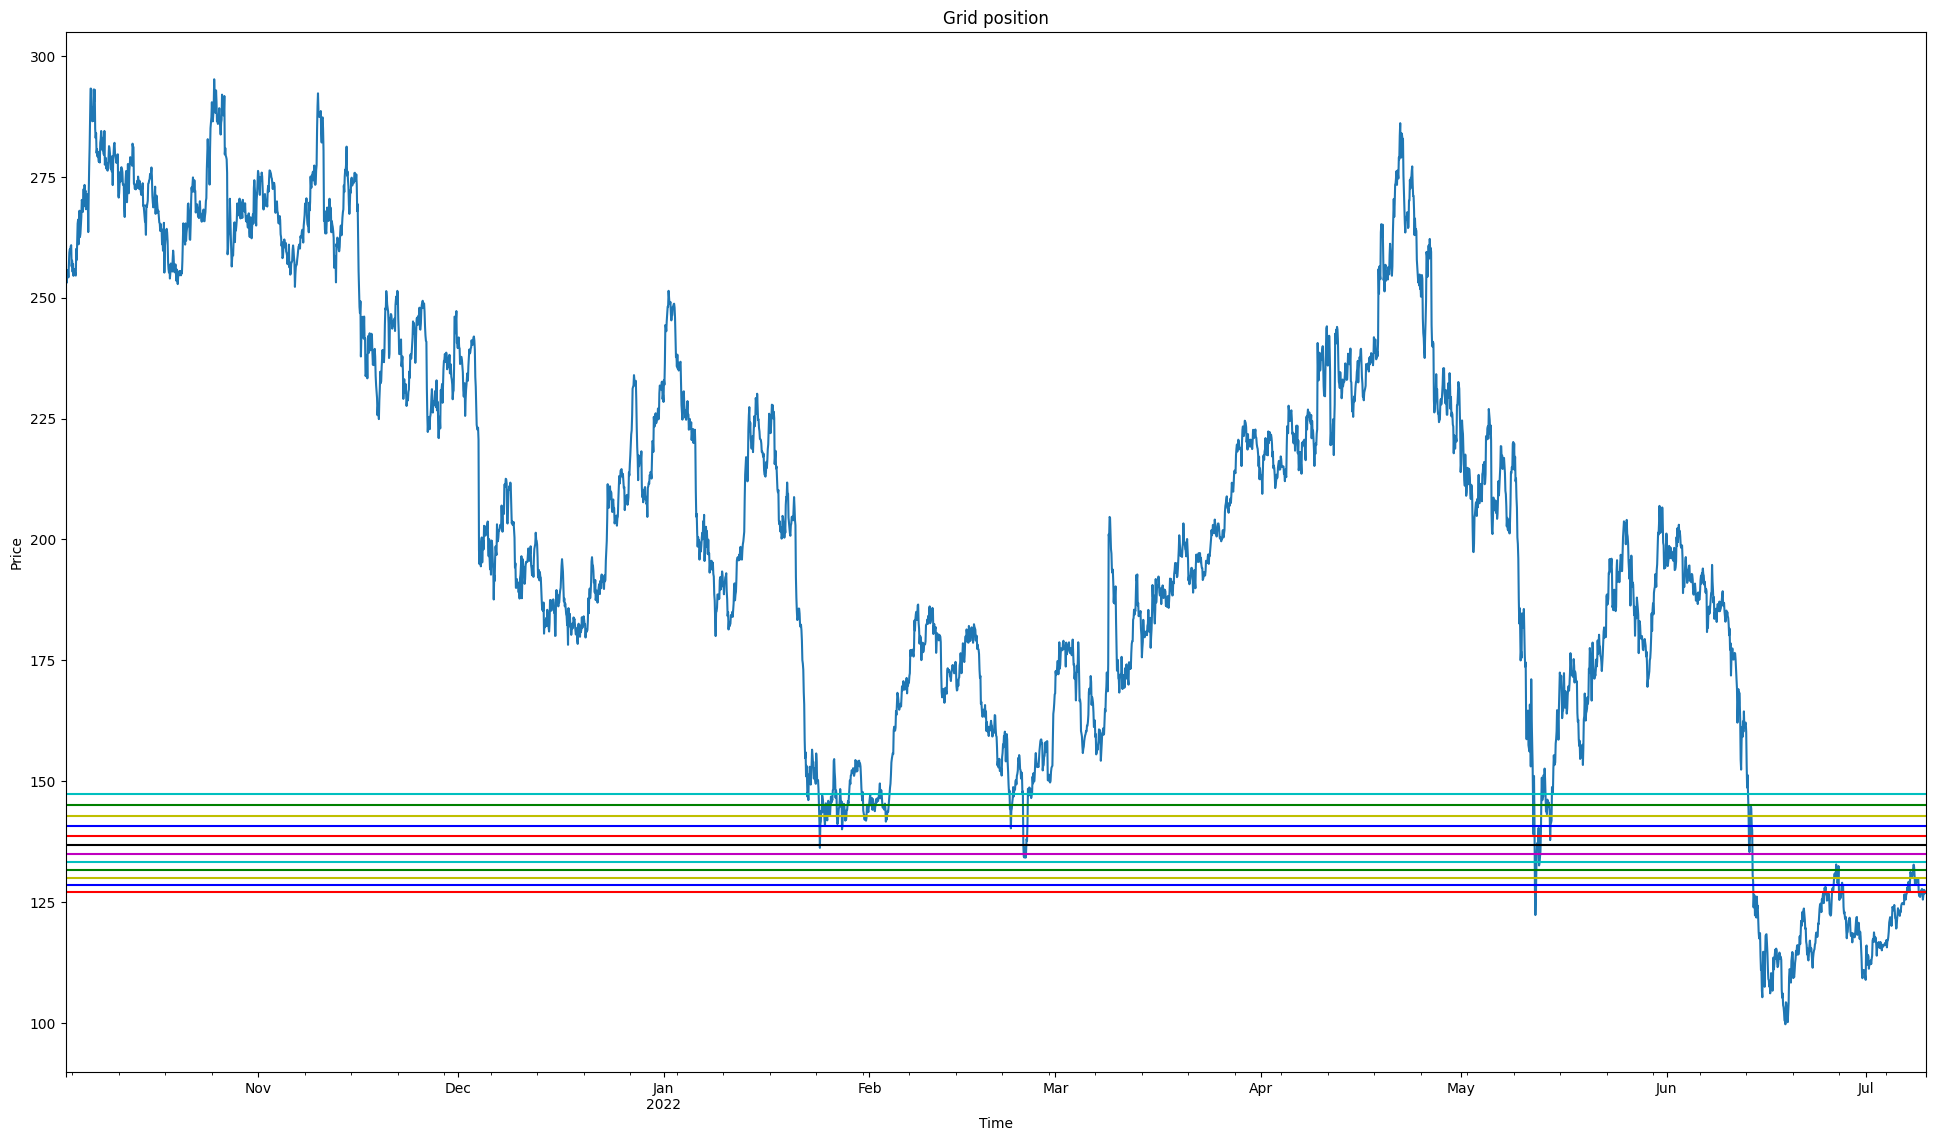

In [22]:
balance = config_to_test["starting_balance"]
lowest_ask = df.price.iloc[-1]

inverse = config_to_test["inverse"]
do_short = True
qty_step = config_to_test["qty_step"]
price_step = config_to_test["price_step"]
min_qty = config_to_test["min_qty"]
min_cost = config_to_test["min_cost"]
c_mult = config_to_test["c_mult"]

grid_span = config_to_test["short"]["grid_span"]
wallet_exposure_limit = config_to_test["short"]["wallet_exposure_limit"]
max_n_entry_orders = config_to_test["short"]["max_n_entry_orders"]
initial_qty_pct = config_to_test["short"]["initial_qty_pct"]
eqty_exp_base = config_to_test["short"]["eqty_exp_base"]
eprice_exp_base = config_to_test["short"]["eprice_exp_base"]

grid = calc_whole_neat_entry_grid_short(
    balance,
    lowest_ask,
    inverse,
    qty_step,
    price_step,
    min_qty,
    min_cost,
    c_mult,
    grid_span,
    wallet_exposure_limit,
    max_n_entry_orders,
    initial_qty_pct,
    eqty_exp_base,
    eprice_exp_base,
)
gdf = pd.DataFrame(grid, columns=["qty", "price", "psize", "pprice", "wallet_exposure"])

gdf.loc[:, "eprice_pprice_diff"] = abs(gdf.price - gdf.pprice) / gdf.price
gdf.loc[:, "ddown_factor"] = gdf.qty / gdf.psize.shift()
gdf.loc[:, "bkr_price"] = gdf.apply(
    lambda x: calc_bankruptcy_price(balance, x.psize, x.pprice, 0.0, 0.0, inverse, c_mult),
    axis=1,
)
colors = "rbygcmk"

# Display grid on graph
# -- = pprice = new position price
# - = price = DCA entry
timedt = pd.to_datetime(timestamps, unit="ms")
dfx = pd.DataFrame({"timestamp": timedt, "price": prices}).set_index("timestamp")
lastdayfrom = pd.to_datetime(Args().end_date)
# lastdayfrom = pd.Timestamp('2021-05-21')
plt = (
    dfx.price.loc[lastdayfrom - pd.Timedelta(days=280) : lastdayfrom]
    .iloc[::100]
    .plot(title="Grid position", xlabel="Time", ylabel="Price")
)
for i, e in enumerate(gdf.itertuples()):
    plt.axhline(y=e.price, color=f"{colors[i%len(colors)]}", linestyle="-")
    # plt.axhline(y=e.pprice, color=f"{colors[i%len(colors)]}", linestyle="--")

In [23]:
a = (1 - gdf.iloc[[0, -1]]["price"].iat[-1] / gdf.iloc[[0, -1]]["price"].iat[0]) * 100
print("\nShort Grid Span = {:.2f} %\n".format(round(a, 2)))
gdf


Short Grid Span = -16.00 %



,qty,price,psize,pprice,wallet_exposure,eprice_pprice_diff,ddown_factor,bkr_price
0,-0.708,127.03,-0.708,127.0300000000,0.008993724,0.0000000000,NaN,14251.3237853107
1,-0.742,128.47,-1.450,127.7668827586,0.018526198,0.0054730072,1.0480225989,7024.3186068966
2,-0.804,129.97,-2.254,128.5527329193,0.028975786,0.0109045709,0.5544827586,4565.1099645075
3,-0.914,131.55,-3.168,129.4174747475,0.040999456,0.0162107583,0.4055013310,3285.9831313131
4,-1.113,133.20,-4.281,130.4008782995,0.055824616,0.0210144272,0.3513257576,2466.3037047419
5,-1.471,134.94,-5.752,131.5617002782,0.075674290,0.0250355693,0.3436113058,1870.0874304590
6,-2.116,136.77,-7.868,132.9624072191,0.104614822,0.0278393857,0.3678720445,1403.9334290798
7,-3.276,138.68,-11.144,134.6432071070,0.150046390,0.0291086883,0.4163701068,1031.9870692749
8,-5.365,140.70,-16.509,136.6115088739,0.225531940,0.0290582170,0.4814249821,742.3417166394
9,-9.125,142.81,-25.634,138.8180014824,0.355846065,0.0279532142,0.5527288146,528.9248907701
